In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from dim_reduction_utils import DimensionalityReduction, EvaluationMetrics

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Seed for reproducibility
np.random.seed(42)

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

# Convert to numpy arrays
X_np = X.values if hasattr(X, 'values') else X
y_np = np.array(y, dtype=int)

# Display basic information about the dataset
print(f"MNIST Dataset: {X_np.shape[0]} samples with {X_np.shape[1]} features")
print(f"Number of classes: {len(np.unique(y_np))}")


MNIST Dataset: 70000 samples with 784 features
Number of classes: 10


In [3]:
sample_size = 5000
indices = np.random.choice(X_np.shape[0], sample_size, replace=False)
X = X_np[indices]
y = y_np[indices]

# Scale the data to standardize pixel values
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"\nWorking dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")


Working dataset shape: (5000, 784)
Number of features: 784
Number of samples: 5000
Number of classes: 10
Class distribution: [490 551 483 556 433 476 490 515 489 517]


In [4]:
def plot_original_digits(X, y, n_samples=25):
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray_r')
        plt.title(f"Digit: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Sample MNIST Digits", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [5]:
def plot_density_distribution(X_reduced, y, title, n_classes=10):
    plt.figure(figsize=(15, 6))
    
    # First component density
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        if np.sum(y == i) > 0:  # Only plot if class exists in subset
            sns.kdeplot(X_reduced[y == i, 0], label=f'Digit {i}', fill=True, alpha=0.3)
    plt.title(f'{title} - Component 1 Density')
    plt.xlabel('Component 1')
    plt.ylabel('Density')
    plt.legend()
    
    # Second component density (if available)
    if X_reduced.shape[1] > 1:
        plt.subplot(1, 2, 2)
        for i in range(n_classes):
            if np.sum(y == i) > 0:  # Only plot if class exists in subset
                sns.kdeplot(X_reduced[y == i, 1], label=f'Digit {i}', fill=True, alpha=0.3)
        plt.title(f'{title} - Component 2 Density')
        plt.xlabel('Component 2')
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
dr = DimensionalityReduction(n_components=2, random_state=42)
metrics = EvaluationMetrics(k=5)

# Custom visualization function for MNIST dataset
def visualize_digits(X_reduced, y, title):
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                 c=y, cmap='tab10', alpha=0.7, s=30)
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.set_label('Digit')
    
    # Add some digit images at their projected locations
    np.random.seed(42)
    indices = np.random.choice(len(y), size=20, replace=False)
    
    for idx in indices:
        # Create a small digit image
        digit_img = X[idx].reshape(28, 28)
        img_size = 0.05  # Size of the image in data coordinates
        
        # Add a small white background rectangle
        rect = plt.Rectangle((X_reduced[idx, 0] - img_size/1.5, X_reduced[idx, 1] - img_size/1.5), 
                           img_size*1.3, img_size*1.3, fill=True, color='white', alpha=0.8)
        plt.gca().add_patch(rect)
        
        # Add the digit image
        imagebox = plt.imshow(digit_img, cmap='gray_r', 
                           extent=(X_reduced[idx, 0] - img_size/2, X_reduced[idx, 0] + img_size/2,
                                 X_reduced[idx, 1] - img_size/2, X_reduced[idx, 1] + img_size/2),
                           interpolation='bilinear', zorder=2)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

PCA Metrics:
Trustworthiness: 0.6706
Continuity: 0.9324
KNN Accuracy: 0.3060
Silhouette Score: -0.0751


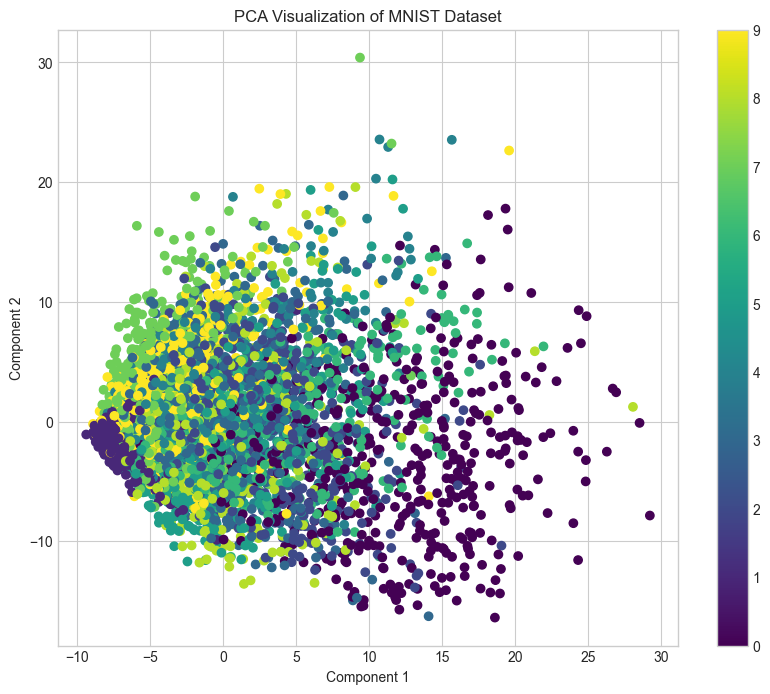

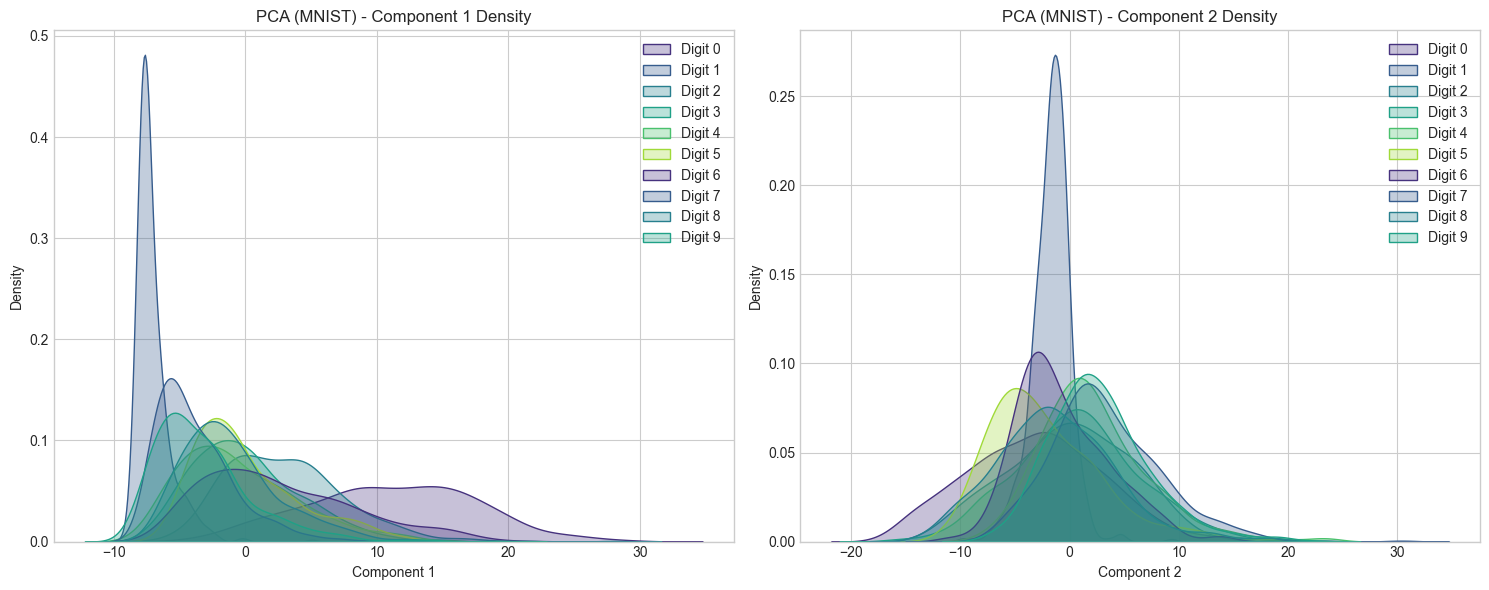

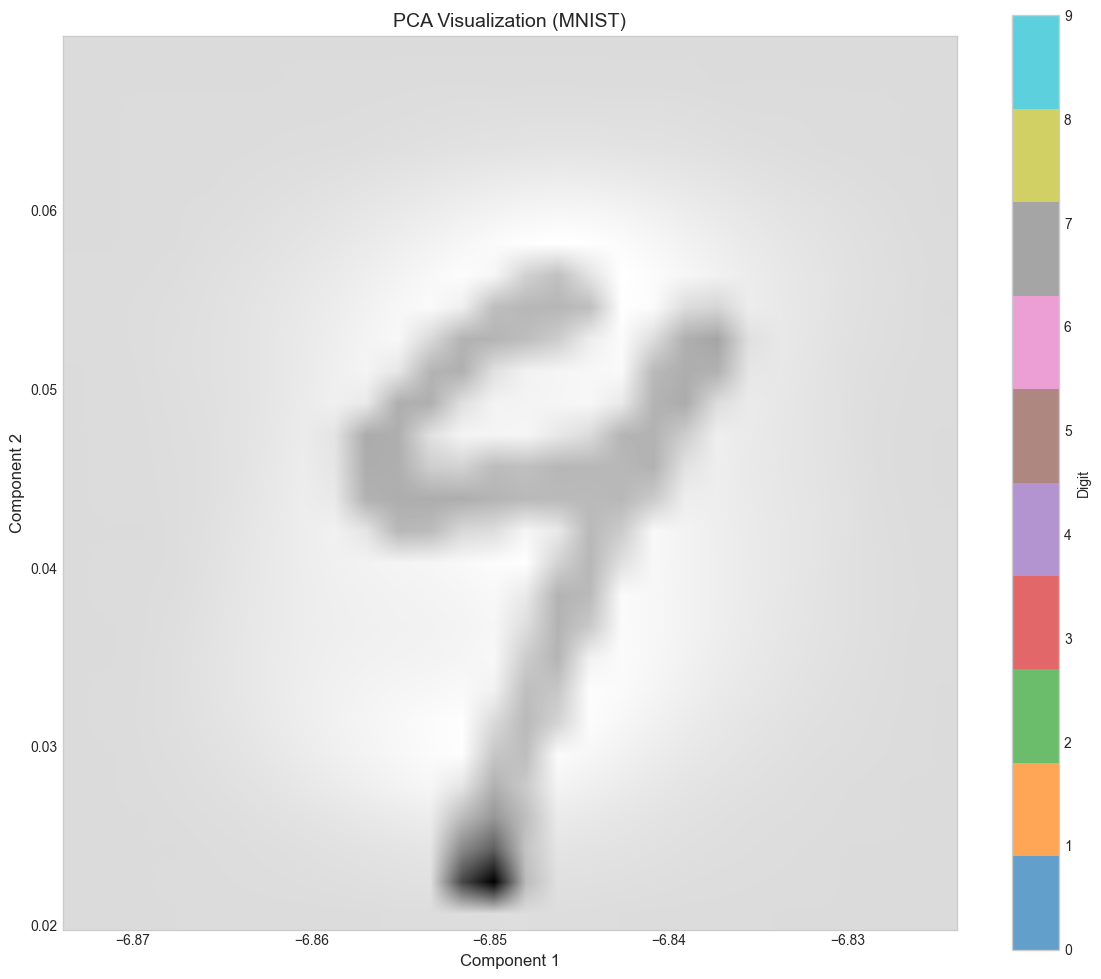

In [11]:
X_pca = dr.pca(X)

# Evaluate PCA
trust_pca = metrics.trustworthiness(X, X_pca)
cont_pca = metrics.continuity(X, X_pca)
knn_acc_pca = metrics.knn_accuracy(X_pca, y)
sil_score_pca = metrics.silhouette_score(X_pca, y)

print(f"PCA Metrics:")
print(f"Trustworthiness: {trust_pca:.4f}")
print(f"Continuity: {cont_pca:.4f}")
print(f"KNN Accuracy: {knn_acc_pca:.4f}")
print(f"Silhouette Score: {sil_score_pca:.4f}")

# Visualize PCA results using the custom digit visualization

metrics.visualize(X_pca, y, title="PCA Visualization of MNIST Dataset")
# Plot density distribution for digits
plot_density_distribution(X_pca, y, "PCA (MNIST)")
visualize_digits(X_pca, y, "PCA Visualization (MNIST)")

LDA Metrics:
Trustworthiness: 0.6201
Continuity: 0.8831
KNN Accuracy: 0.4850
Silhouette Score: 0.0374


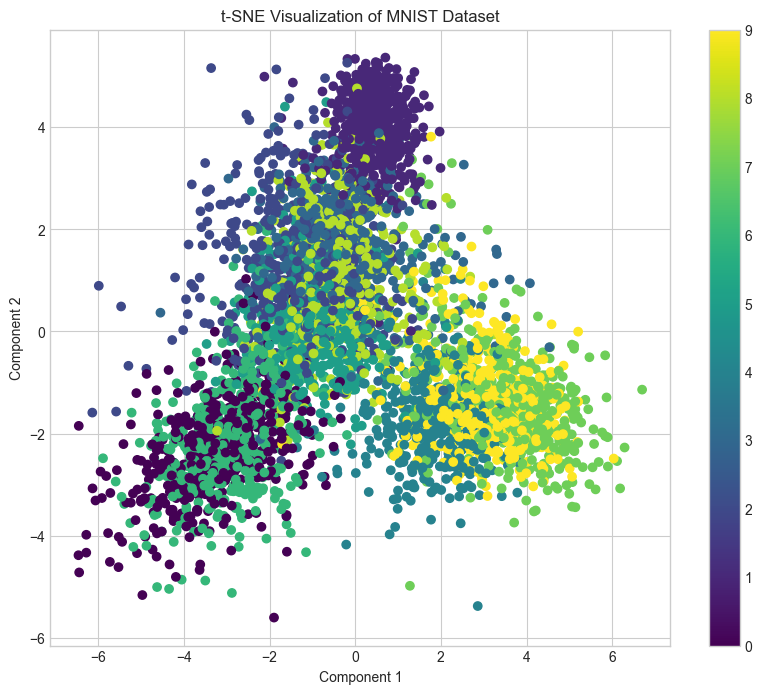

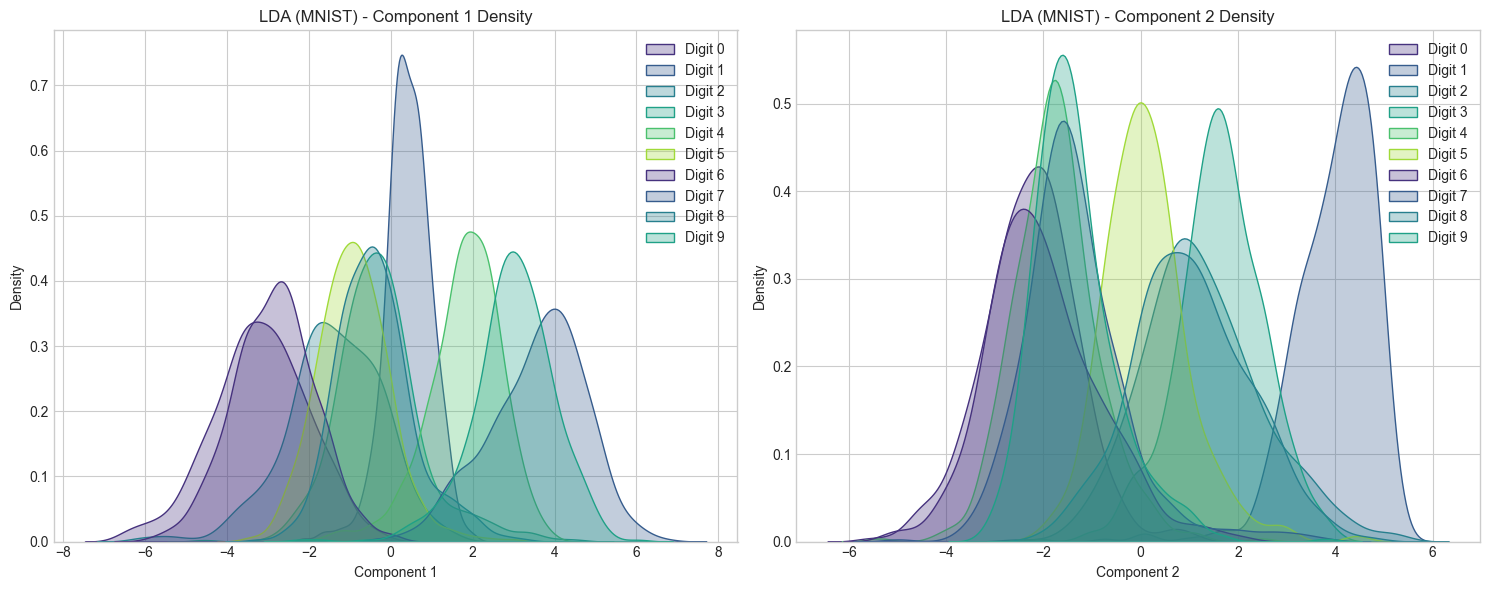

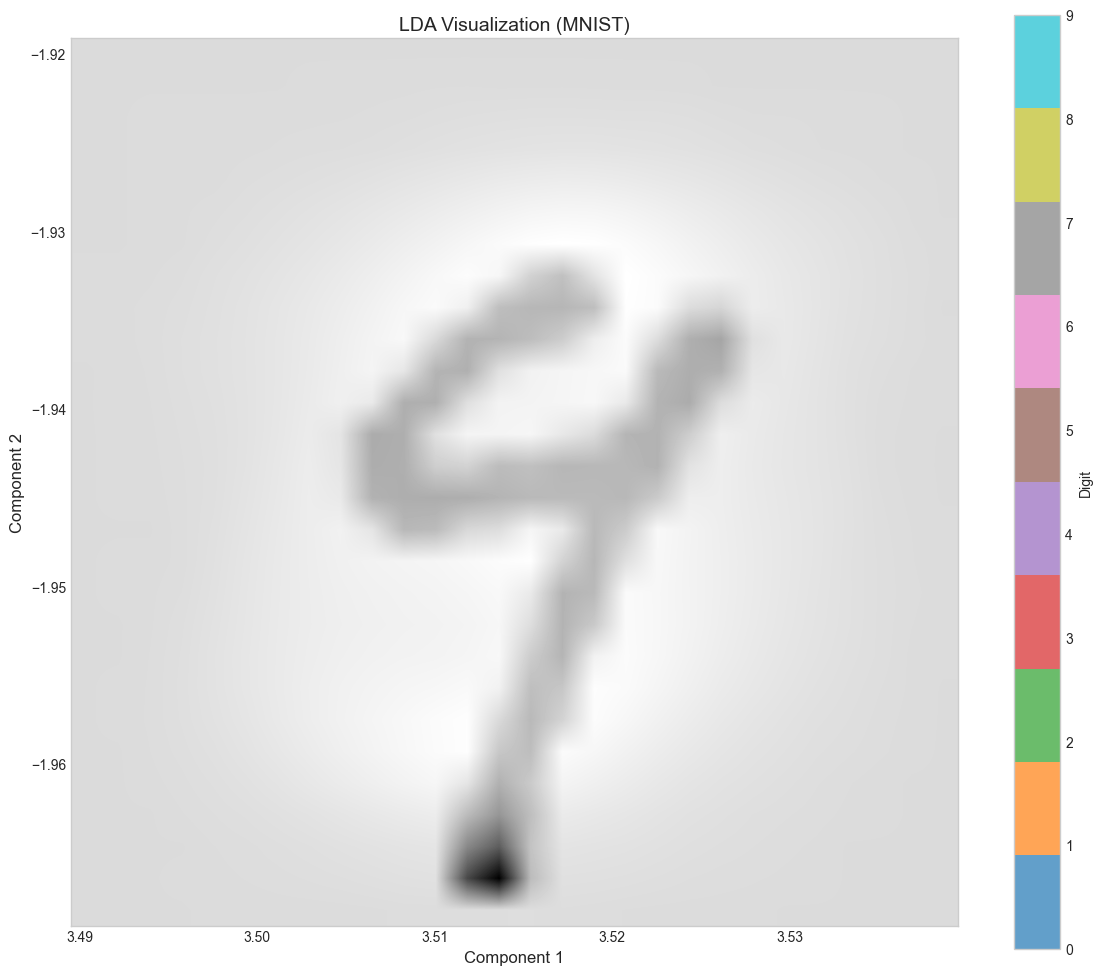

In [13]:
dr_lda = DimensionalityReduction(n_components=2, random_state=42)
X_lda = dr_lda.lda(X, y)

# Evaluate LDA
trust_lda = metrics.trustworthiness(X, X_lda)
cont_lda = metrics.continuity(X, X_lda)
knn_acc_lda = metrics.knn_accuracy(X_lda, y)
sil_score_lda = metrics.silhouette_score(X_lda, y)

print(f"LDA Metrics:")
print(f"Trustworthiness: {trust_lda:.4f}")
print(f"Continuity: {cont_lda:.4f}")
print(f"KNN Accuracy: {knn_acc_lda:.4f}")
print(f"Silhouette Score: {sil_score_lda:.4f}")

# Visualize LDA results

metrics.visualize(X_lda, y, title="LDA Visualization of MNIST Dataset")
# Plot density distribution
plot_density_distribution(X_lda, y, "LDA (MNIST)")
visualize_digits(X_lda, y, "LDA Visualization (MNIST)")

c:\Users\LapTop\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\LapTop\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\LapTop\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\LapTop\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\LapTop\AppData\Local\Programs\Python\Python310\lib

t-SNE Metrics:
Trustworthiness: 0.9680
Continuity: 0.9705
KNN Accuracy: 0.8900
Silhouette Score: 0.0972


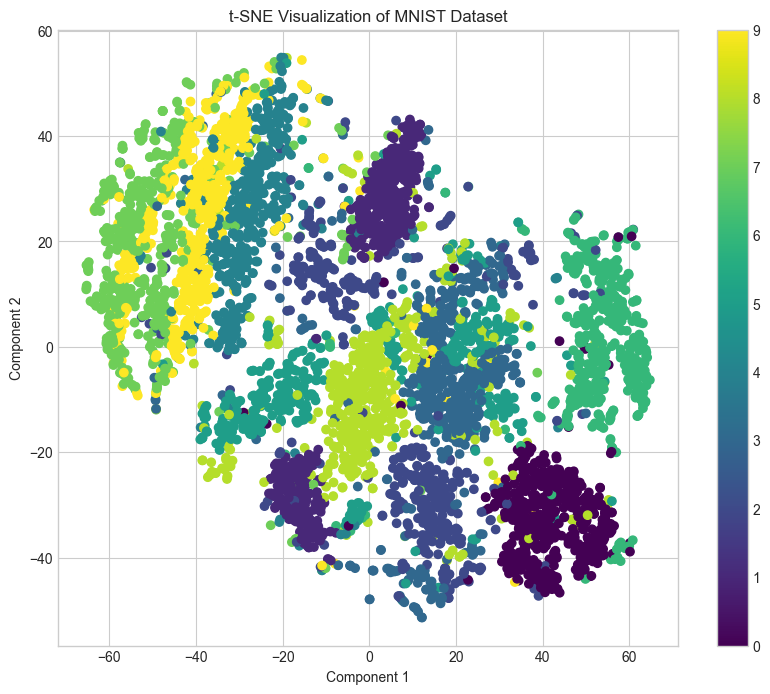

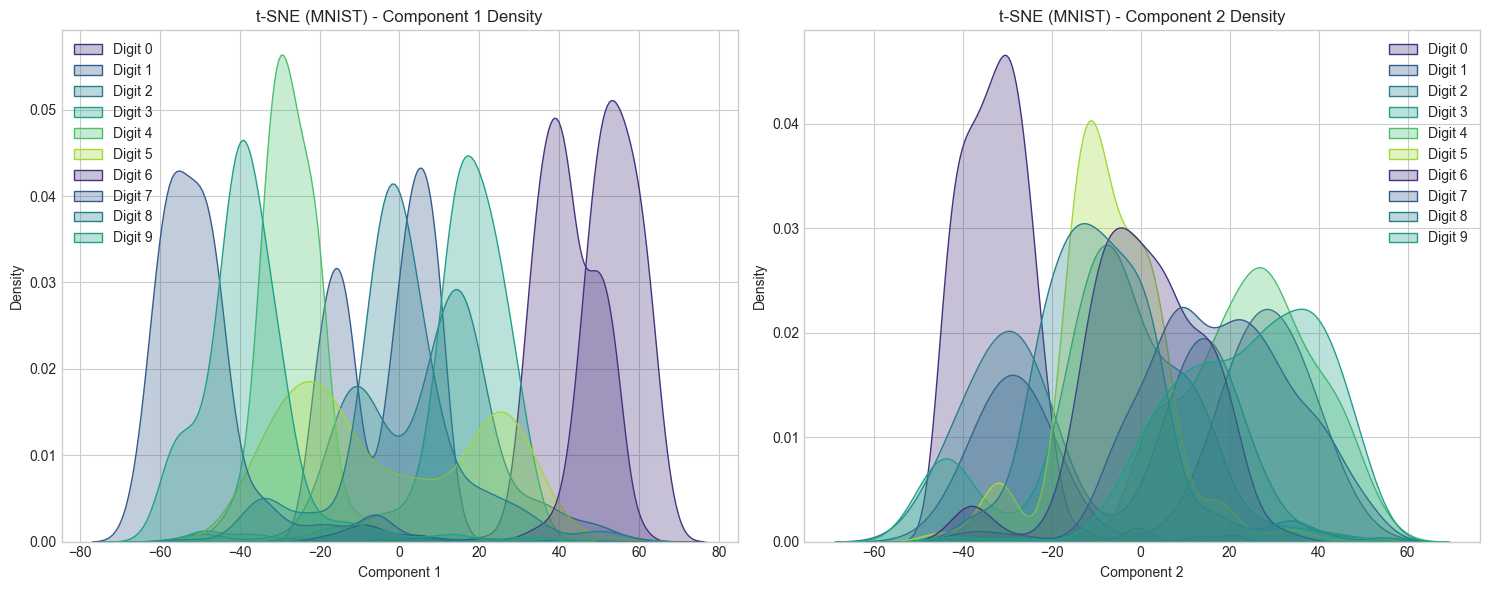

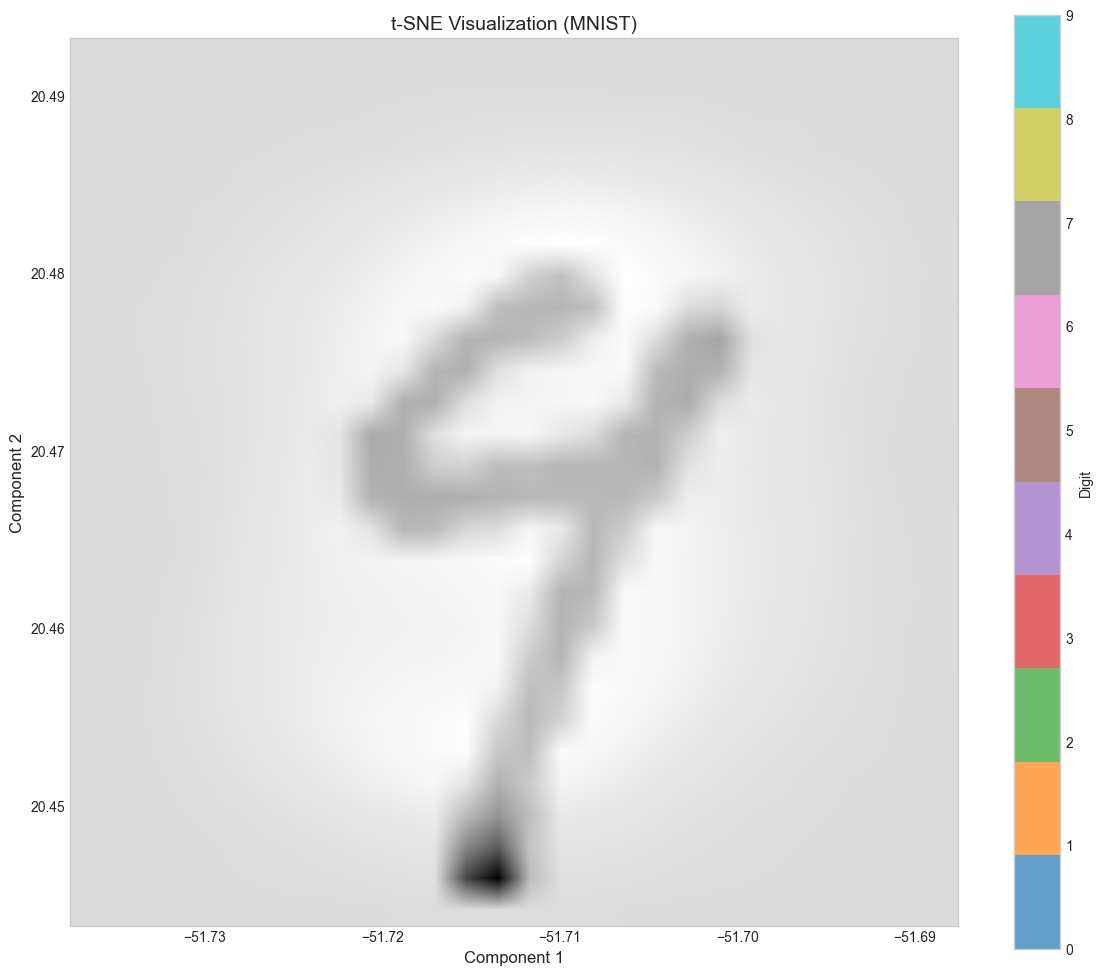

In [14]:
X_tsne = dr.tsne(X, perplexity=50)

# Evaluate t-SNE
trust_tsne = metrics.trustworthiness(X, X_tsne)
cont_tsne = metrics.continuity(X, X_tsne)
knn_acc_tsne = metrics.knn_accuracy(X_tsne, y)
sil_score_tsne = metrics.silhouette_score(X_tsne, y)

print(f"t-SNE Metrics:")
print(f"Trustworthiness: {trust_tsne:.4f}")
print(f"Continuity: {cont_tsne:.4f}")
print(f"KNN Accuracy: {knn_acc_tsne:.4f}")
print(f"Silhouette Score: {sil_score_tsne:.4f}")

# Visualize t-SNE results

metrics.visualize(X_tsne, y, title="t-SNE Visualization of MNIST Dataset")
# Plot density distribution
plot_density_distribution(X_tsne, y, "t-SNE (MNIST)")
visualize_digits(X_tsne, y, "t-SNE Visualization (MNIST)")

MDS Metrics (on 1000-sample subset):
Trustworthiness: 0.6901
Continuity: 0.8402
KNN Accuracy: 0.4300
Silhouette Score: -0.1014


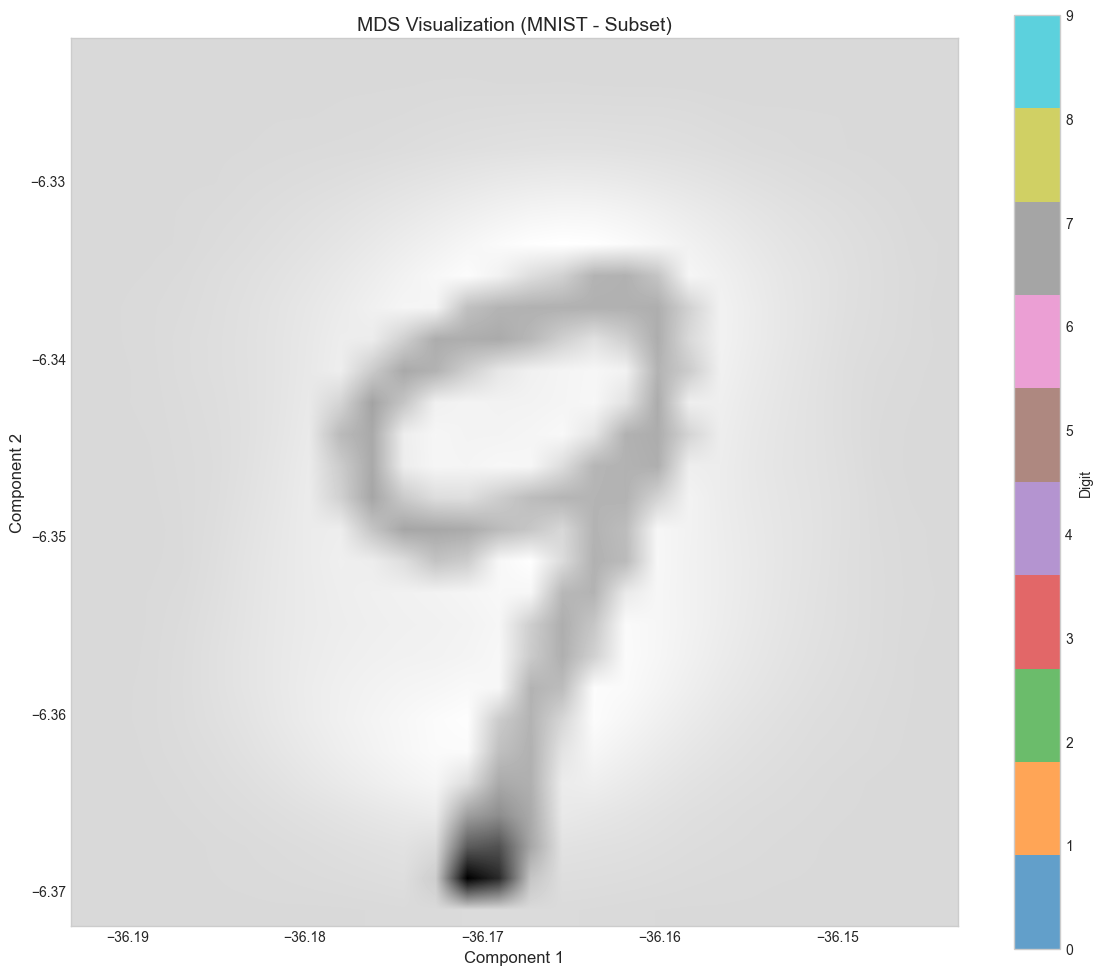

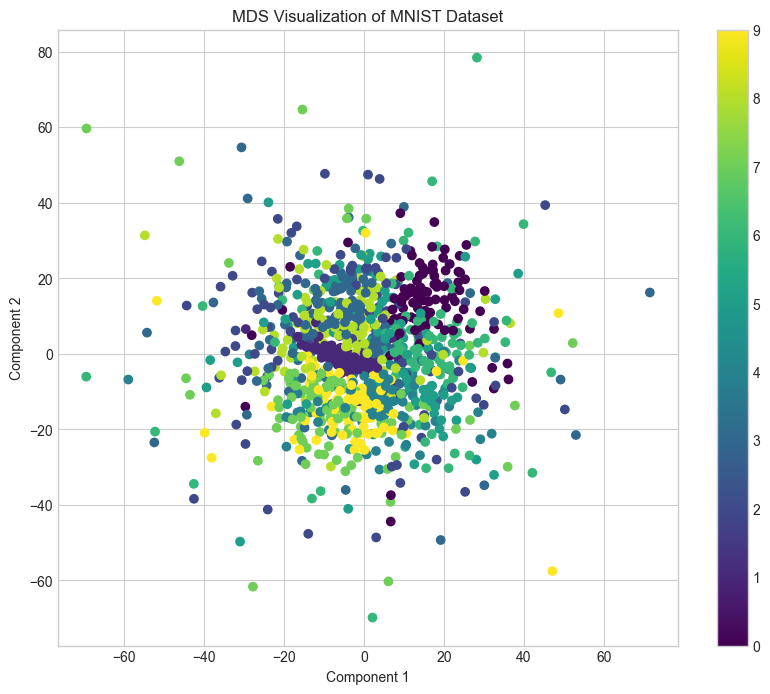

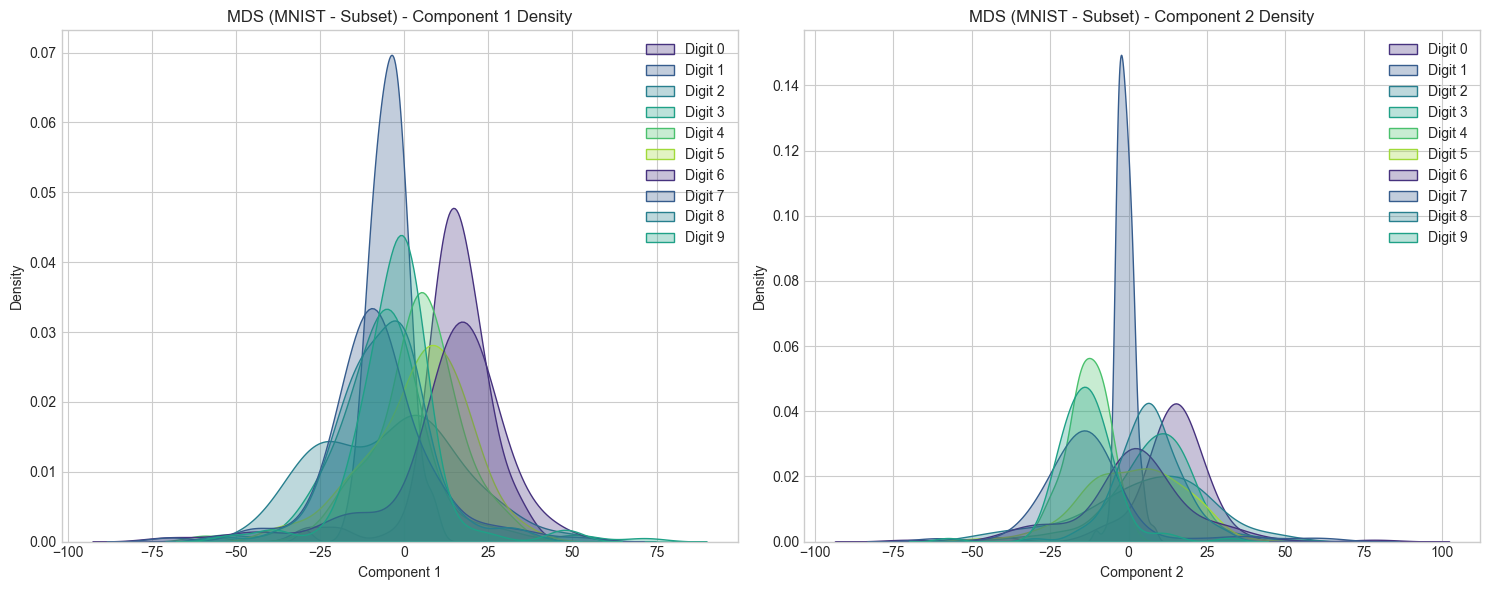

In [15]:
sample_size_mds = 1000  # Using just 1000 samples for MDS
indices_mds = np.random.choice(X.shape[0], sample_size_mds, replace=False)
X_mds_subset = X[indices_mds]
y_mds_subset = y[indices_mds]

X_mds = dr.mds(X_mds_subset)

# Evaluate MDS on the subset
trust_mds = metrics.trustworthiness(X_mds_subset, X_mds)
cont_mds = metrics.continuity(X_mds_subset, X_mds)
knn_acc_mds = metrics.knn_accuracy(X_mds, y_mds_subset)
sil_score_mds = metrics.silhouette_score(X_mds, y_mds_subset)

print(f"MDS Metrics (on {sample_size_mds}-sample subset):")
print(f"Trustworthiness: {trust_mds:.4f}")
print(f"Continuity: {cont_mds:.4f}")
print(f"KNN Accuracy: {knn_acc_mds:.4f}")
print(f"Silhouette Score: {sil_score_mds:.4f}")

# Visualize MDS results
visualize_digits(X_mds, y_mds_subset, "MDS Visualization (MNIST - Subset)")
metrics.visualize(X_mds, y_mds_subset, title="MDS Visualization of MNIST Dataset")
# Plot density distribution
plot_density_distribution(X_mds, y_mds_subset, "MDS (MNIST - Subset)")

Isomap Metrics (on 1000-sample subset):
Trustworthiness: 0.7001
Continuity: 0.9222
KNN Accuracy: 0.4550
Silhouette Score: -0.0492


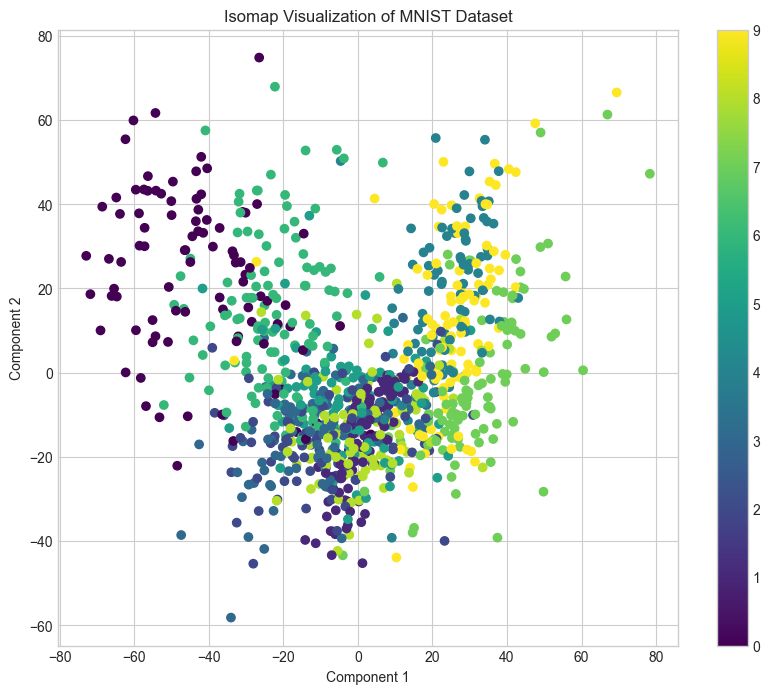

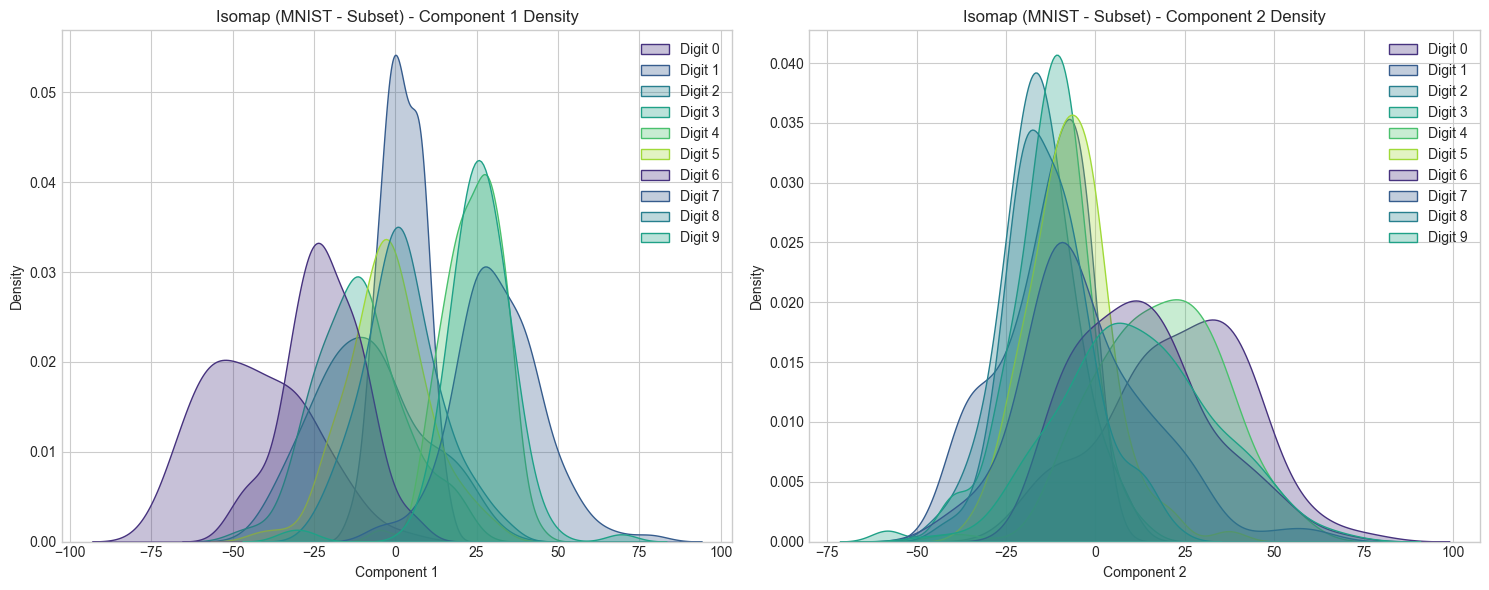

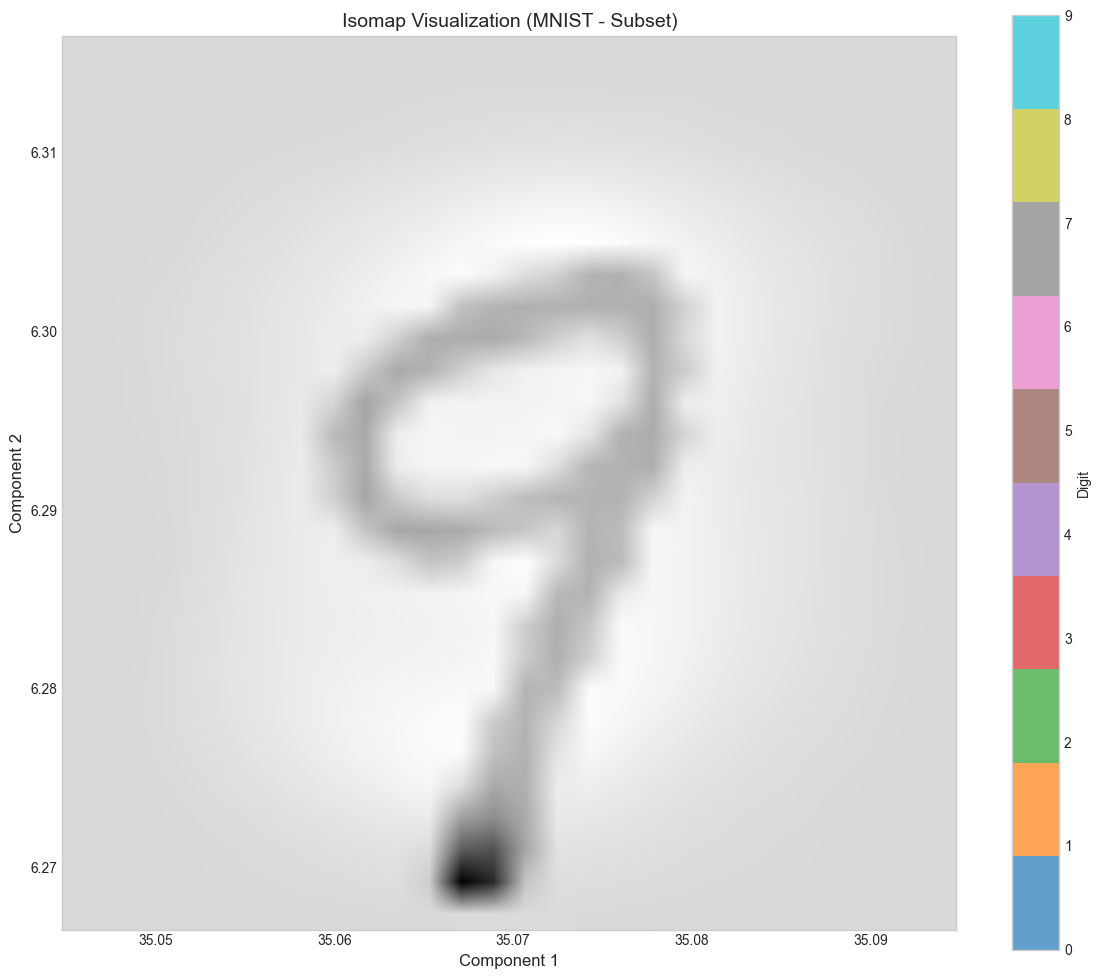

In [16]:
sample_size_isomap = 1000
indices_isomap = np.random.choice(X.shape[0], sample_size_isomap, replace=False)
X_isomap_subset = X[indices_isomap]
y_isomap_subset = y[indices_isomap]

X_isomap = dr.isomap(X_isomap_subset, n_neighbors=10)

# Evaluate Isomap on the subset
trust_isomap = metrics.trustworthiness(X_isomap_subset, X_isomap)
cont_isomap = metrics.continuity(X_isomap_subset, X_isomap)
knn_acc_isomap = metrics.knn_accuracy(X_isomap, y_isomap_subset)
sil_score_isomap = metrics.silhouette_score(X_isomap, y_isomap_subset)

print(f"Isomap Metrics (on {sample_size_isomap}-sample subset):")
print(f"Trustworthiness: {trust_isomap:.4f}")
print(f"Continuity: {cont_isomap:.4f}")
print(f"KNN Accuracy: {knn_acc_isomap:.4f}")
print(f"Silhouette Score: {sil_score_isomap:.4f}")

# Visualize Isomap results

metrics.visualize(X_isomap, y_isomap_subset, title="Isomap Visualization of MNIST Dataset")
# Plot density distribution
plot_density_distribution(X_isomap, y_isomap_subset, "Isomap (MNIST - Subset)")
visualize_digits(X_isomap, y_isomap_subset, "Isomap Visualization (MNIST - Subset)")

ICA Metrics:
Trustworthiness: 0.5779
Continuity: 0.8474
KNN Accuracy: 0.1660
Silhouette Score: -0.2525


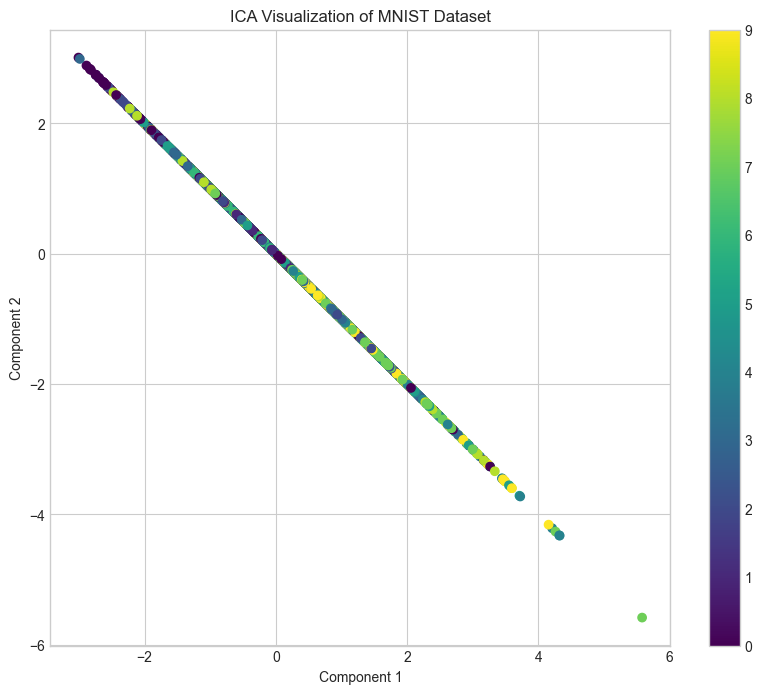

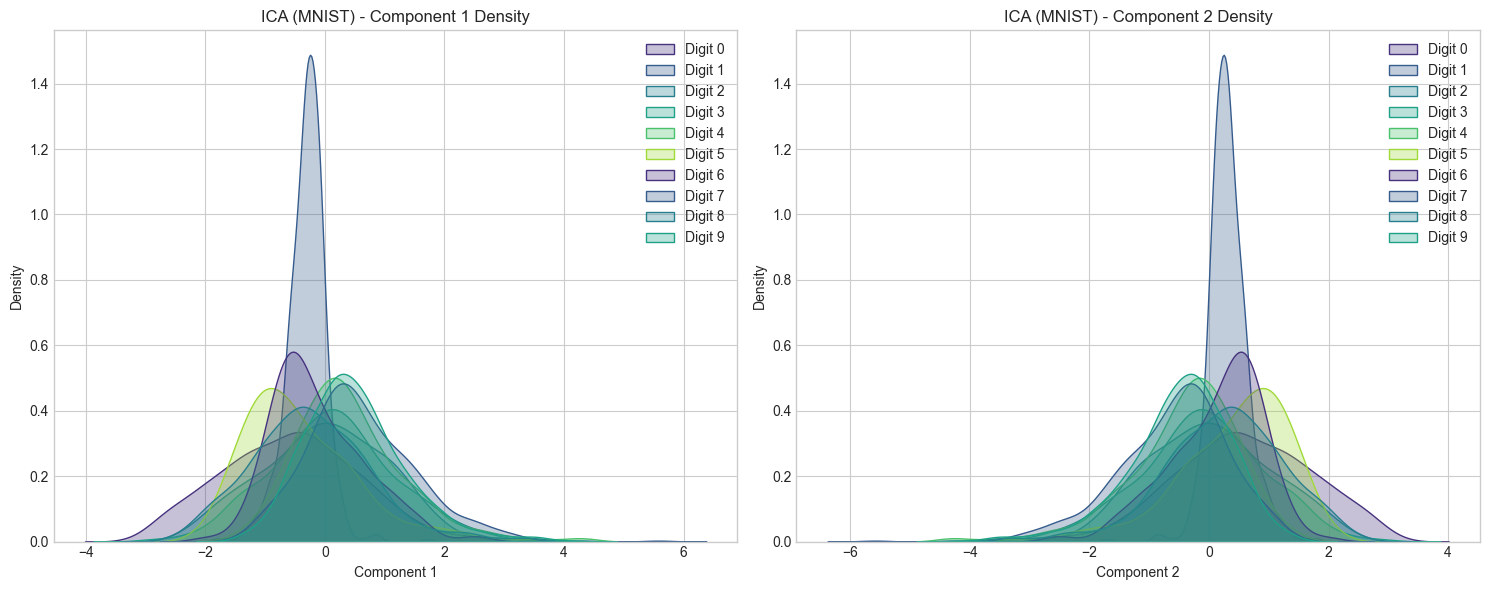

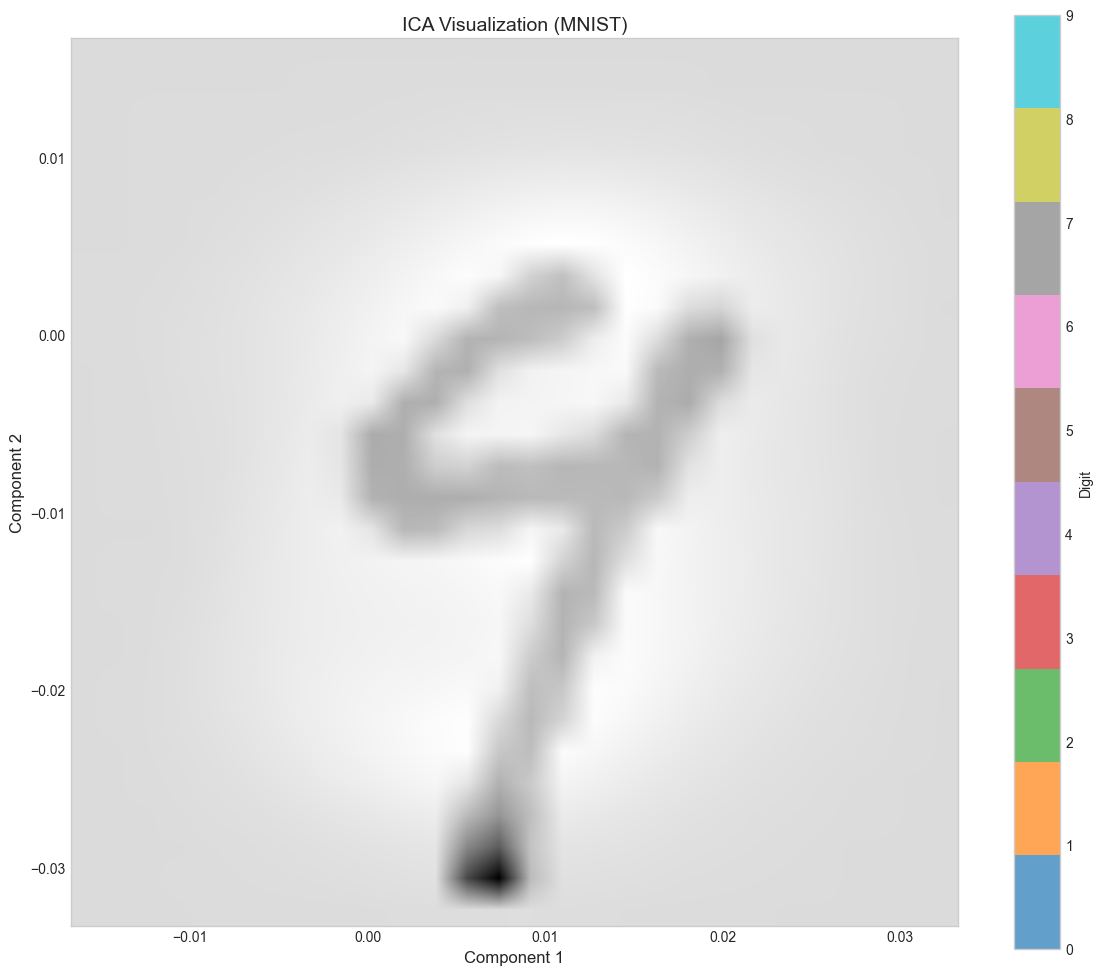

In [17]:
X_ica = dr.ica(X)

# Evaluate ICA
trust_ica = metrics.trustworthiness(X, X_ica)
cont_ica = metrics.continuity(X, X_ica)
knn_acc_ica = metrics.knn_accuracy(X_ica, y)
sil_score_ica = metrics.silhouette_score(X_ica, y)

print(f"ICA Metrics:")
print(f"Trustworthiness: {trust_ica:.4f}")
print(f"Continuity: {cont_ica:.4f}")
print(f"KNN Accuracy: {knn_acc_ica:.4f}")
print(f"Silhouette Score: {sil_score_ica:.4f}")

# Visualize ICA results

metrics.visualize(X_ica, y, title="ICA Visualization of MNIST Dataset")
# Plot density distribution
plot_density_distribution(X_ica, y, "ICA (MNIST)")
visualize_digits(X_ica, y, "ICA Visualization (MNIST)")

Training SOM...


c:\Users\LapTop\AppData\Local\Programs\Python\Python310\lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


SOM Metrics:
Trustworthiness: 0.8806
Continuity: 0.8908
KNN Accuracy: 0.7430
Silhouette Score: -0.0130


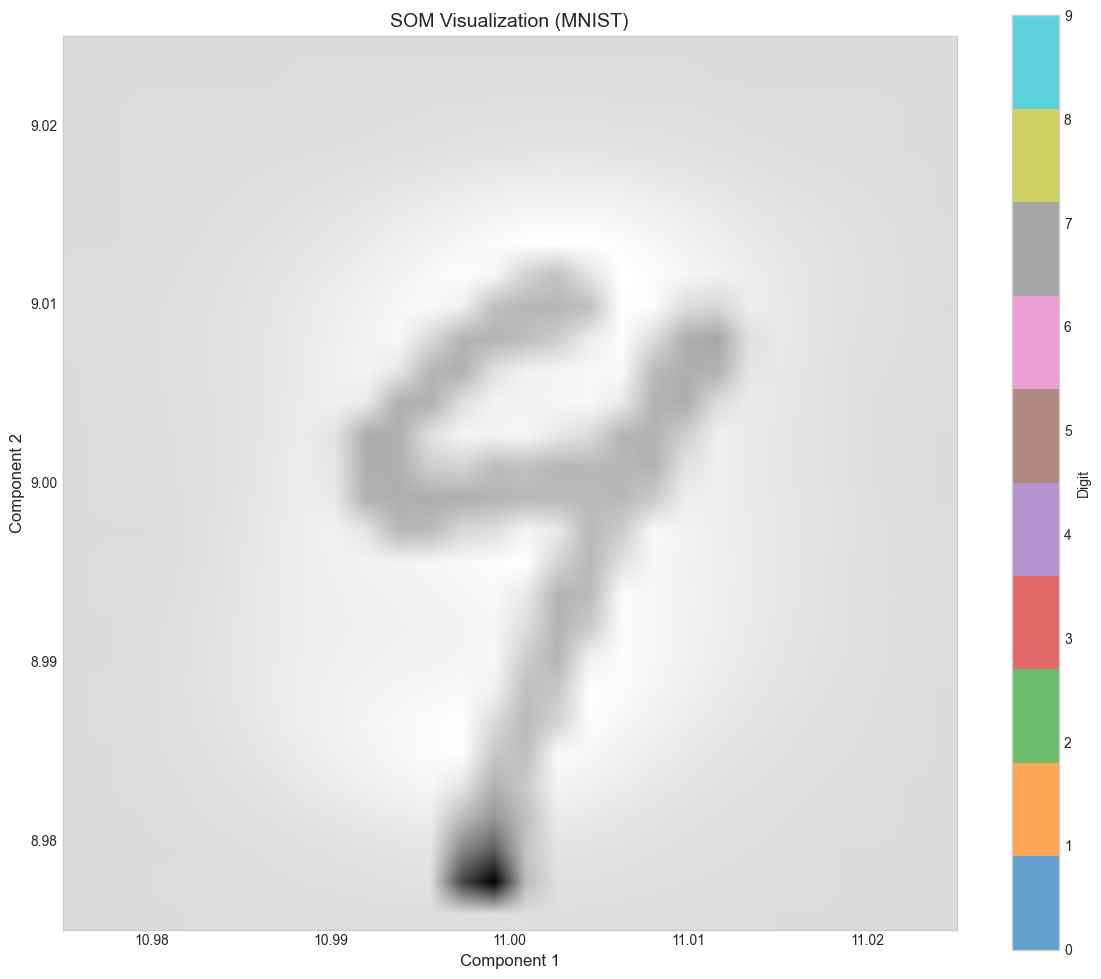

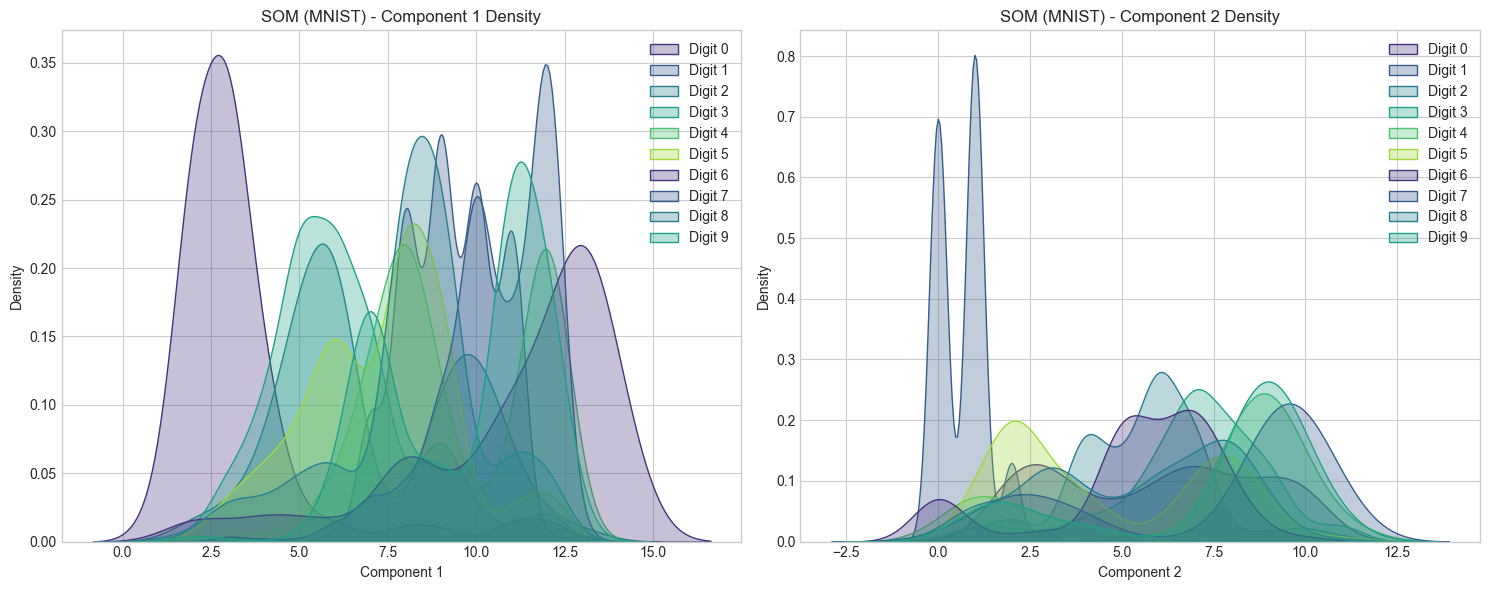

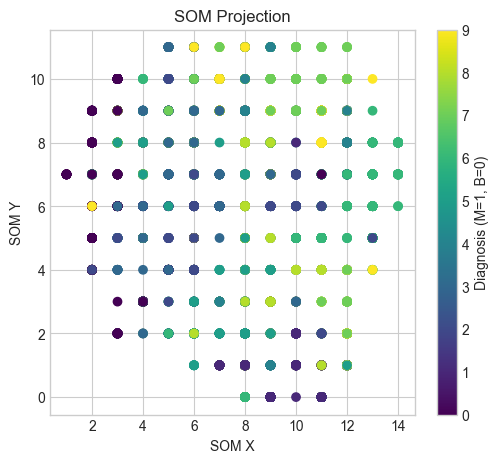

In [21]:
from minisom import MiniSom

# Define grid size for SOM
grid_size = (15, 15)
som = MiniSom(grid_size[0], grid_size[1], X.shape[1], sigma=1.0, learning_rate=0.5, 
              neighborhood_function='gaussian', random_seed=42)

# Initialize and train the SOM
print("Training SOM...")
som.pca_weights_init(X)
som.train(X, 5000)  # Train for 5000 iterations

# Get the 2D projection from SOM
X_som = np.array([som.winner(x) for x in X])
X_som = X_som.astype(float)  # Convert from integer coordinates to float

# Evaluate SOM
trust_som = metrics.trustworthiness(X, X_som)
cont_som = metrics.continuity(X, X_som)
knn_acc_som = metrics.knn_accuracy(X_som, y)
sil_score_som = metrics.silhouette_score(X_som, y)

print(f"SOM Metrics:")
print(f"Trustworthiness: {trust_som:.4f}")
print(f"Continuity: {cont_som:.4f}")
print(f"KNN Accuracy: {knn_acc_som:.4f}")
print(f"Silhouette Score: {sil_score_som:.4f}")

# Visualize SOM results with standard projection view
visualize_digits(X_som, y, "SOM Visualization (MNIST)")

# Plot density distribution
plot_density_distribution(X_som, y, "SOM (MNIST)")

    # Create special visualization for SOM
plt.figure(figsize=(20, 5))
    
    # 1. Scatter plot of SOM coordinates
plt.subplot(131)
scatter = plt.scatter(X_som[:, 0], X_som[:, 1], c=y, cmap='viridis')
plt.title('SOM Projection')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.colorbar(scatter, label='Diagnosis (M=1, B=0)')
   

GA-PCA Metrics (on 1000-sample subset):
Trustworthiness: 0.6589
Continuity: 0.8925
KNN Accuracy: 0.3750
Silhouette Score: -0.0517


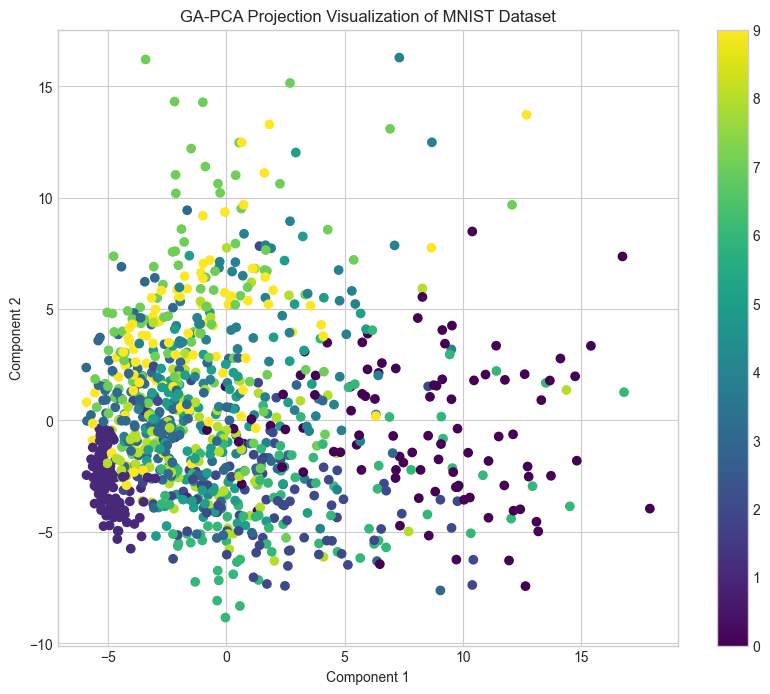

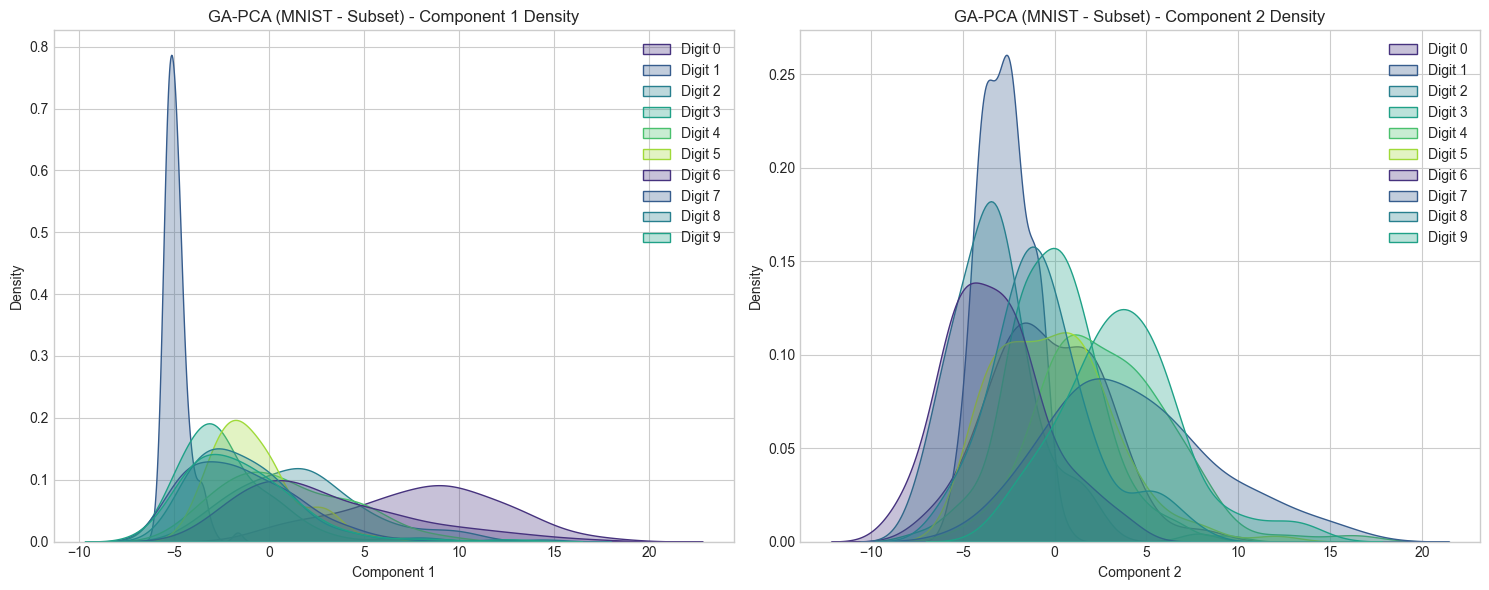

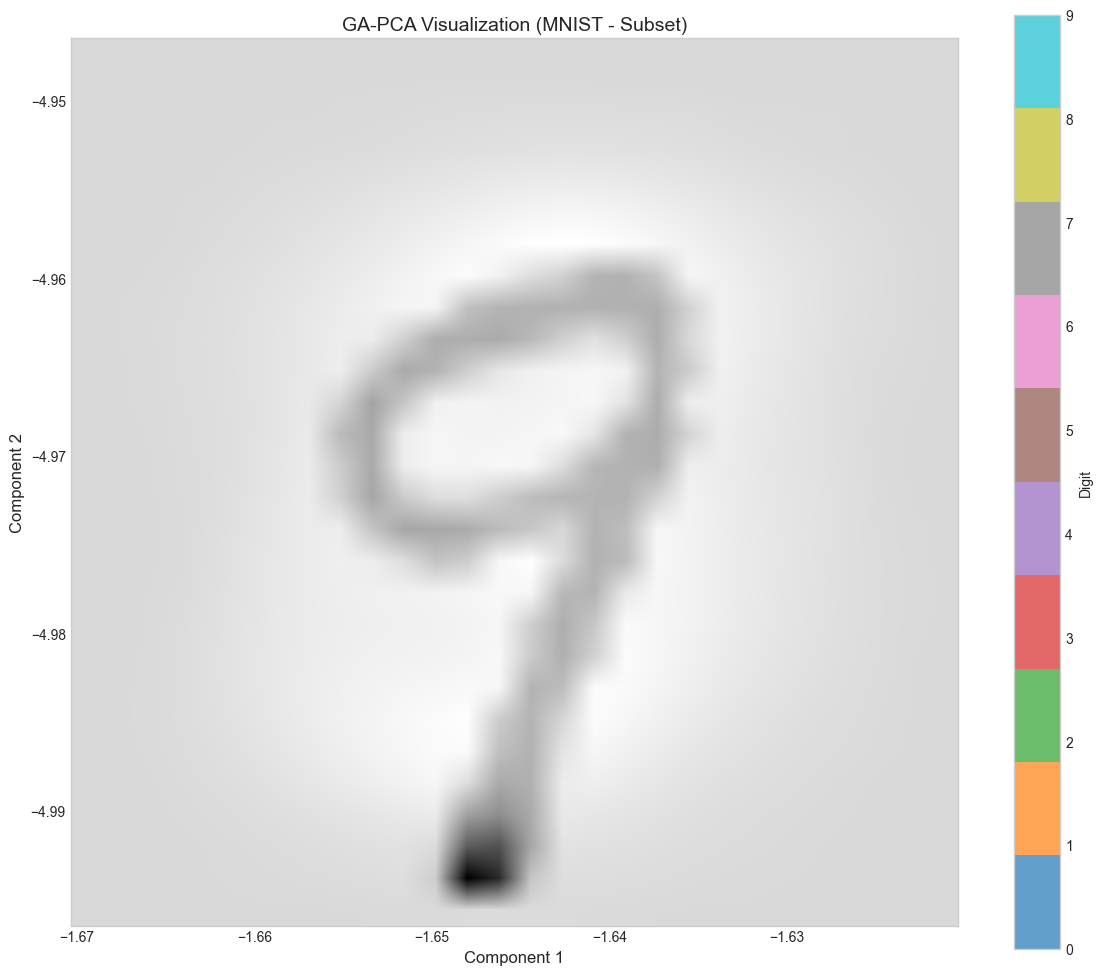

In [22]:
sample_size_ga = 1000
indices_ga = np.random.choice(X.shape[0], sample_size_ga, replace=False)
X_ga_subset = X[indices_ga]
y_ga_subset = y[indices_ga]

X_ga_pca = dr.ga_pca(X_ga_subset, y_ga_subset, population_size=20, generations=20, mutation_rate=0.1)

# Evaluate GA-PCA on the subset
trust_ga_pca = metrics.trustworthiness(X_ga_subset, X_ga_pca)
cont_ga_pca = metrics.continuity(X_ga_subset, X_ga_pca)
knn_acc_ga_pca = metrics.knn_accuracy(X_ga_pca, y_ga_subset)
sil_score_ga_pca = metrics.silhouette_score(X_ga_pca, y_ga_subset)

print(f"GA-PCA Metrics (on {sample_size_ga}-sample subset):")
print(f"Trustworthiness: {trust_ga_pca:.4f}")
print(f"Continuity: {cont_ga_pca:.4f}")
print(f"KNN Accuracy: {knn_acc_ga_pca:.4f}")
print(f"Silhouette Score: {sil_score_ga_pca:.4f}")

# Visualize GA-PCA results
metrics.visualize(X_ga_pca, y_ga_subset, title="GA-PCA Projection Visualization of MNIST Dataset")
# Plot density distribution
plot_density_distribution(X_ga_pca, y_ga_subset, "GA-PCA (MNIST - Subset)")
visualize_digits(X_ga_pca, y_ga_subset, "GA-PCA Visualization (MNIST - Subset)")


ABC Metrics (on 1000-sample subset):
Trustworthiness: 0.5981
Continuity: 0.7794
KNN Accuracy: 0.3300
Silhouette Score: -0.1377


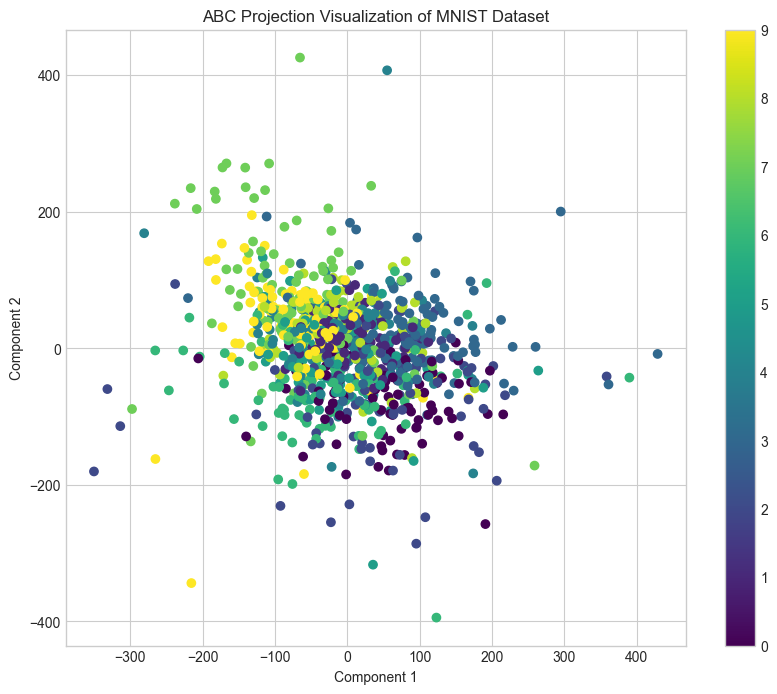

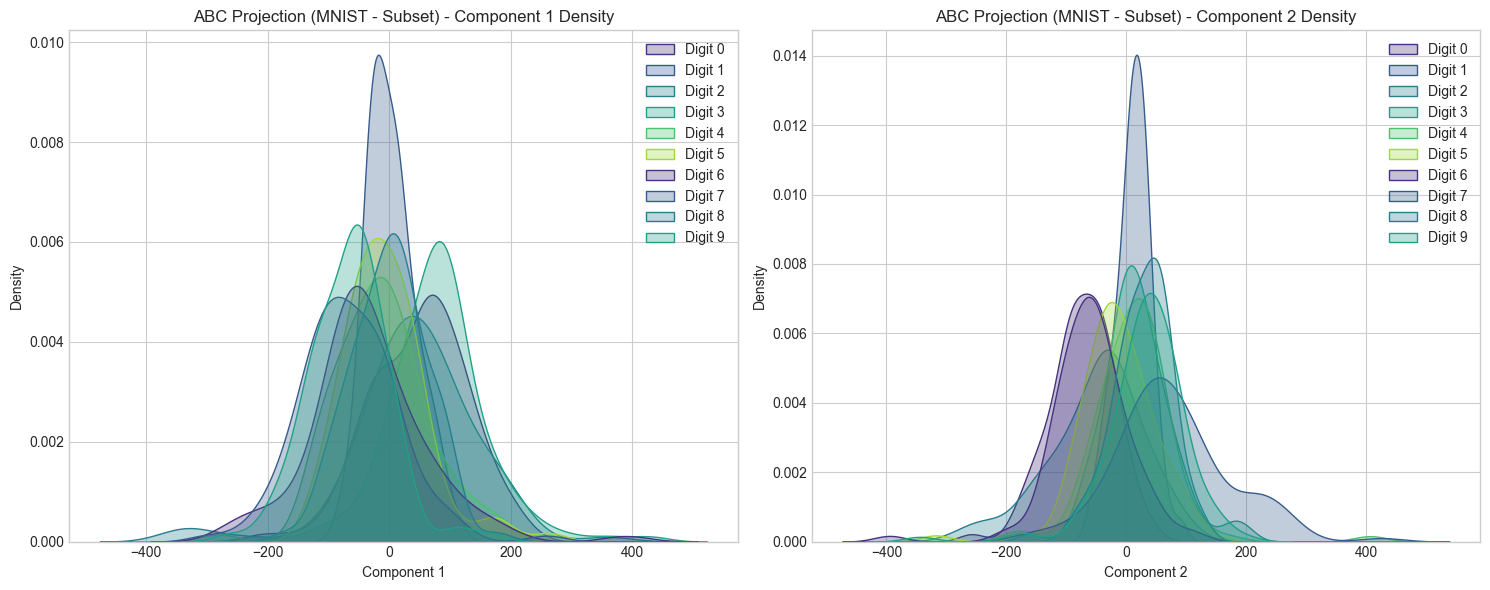

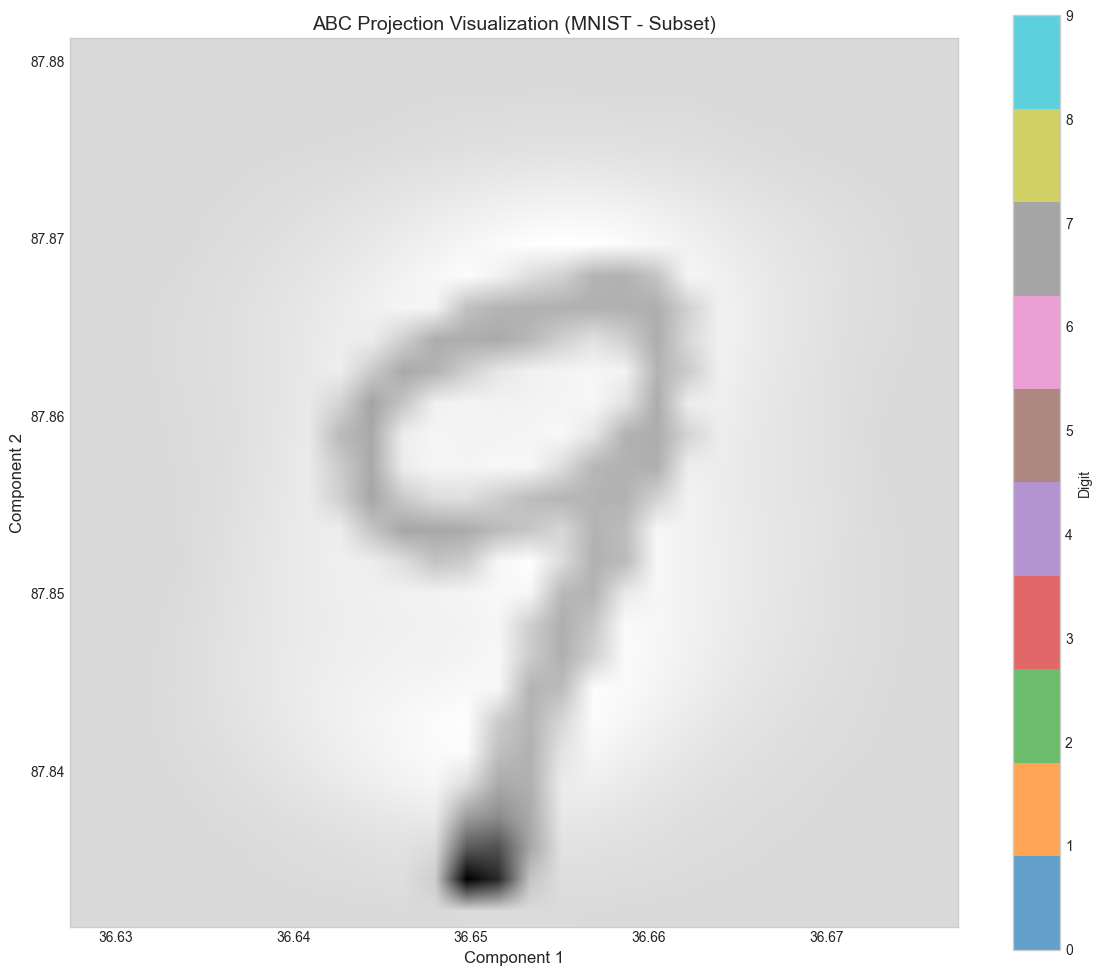

In [25]:
sample_size_abc = 1000
indices_abc = np.random.choice(X.shape[0], sample_size_abc, replace=False)
X_abc_subset = X[indices_abc]
y_abc_subset = y[indices_abc]

X_abc = dr.abc_projection(X_abc_subset, y_abc_subset, n_bees=20, n_iterations=20, limit=3)

# Evaluate ABC on the subset
trust_abc = metrics.trustworthiness(X_abc_subset, X_abc)
cont_abc = metrics.continuity(X_abc_subset, X_abc)
knn_acc_abc = metrics.knn_accuracy(X_abc, y_abc_subset)
sil_score_abc = metrics.silhouette_score(X_abc, y_abc_subset)

print(f"ABC Metrics (on {sample_size_abc}-sample subset):")
print(f"Trustworthiness: {trust_abc:.4f}")
print(f"Continuity: {cont_abc:.4f}")
print(f"KNN Accuracy: {knn_acc_abc:.4f}")
print(f"Silhouette Score: {sil_score_abc:.4f}")

# Visualize ABC results
metrics.visualize(X_abc, y_abc_subset, title="ABC Projection Visualization of MNIST Dataset")



# Plot density distribution
plot_density_distribution(X_abc, y_abc_subset, "ABC Projection (MNIST - Subset)")
visualize_digits(X_abc, y_abc_subset, "ABC Projection Visualization (MNIST - Subset)")

ACO Metrics (on 1000-sample subset):
Trustworthiness: 0.6610
Continuity: 0.8954
KNN Accuracy: 0.4800
Silhouette Score: -0.0058


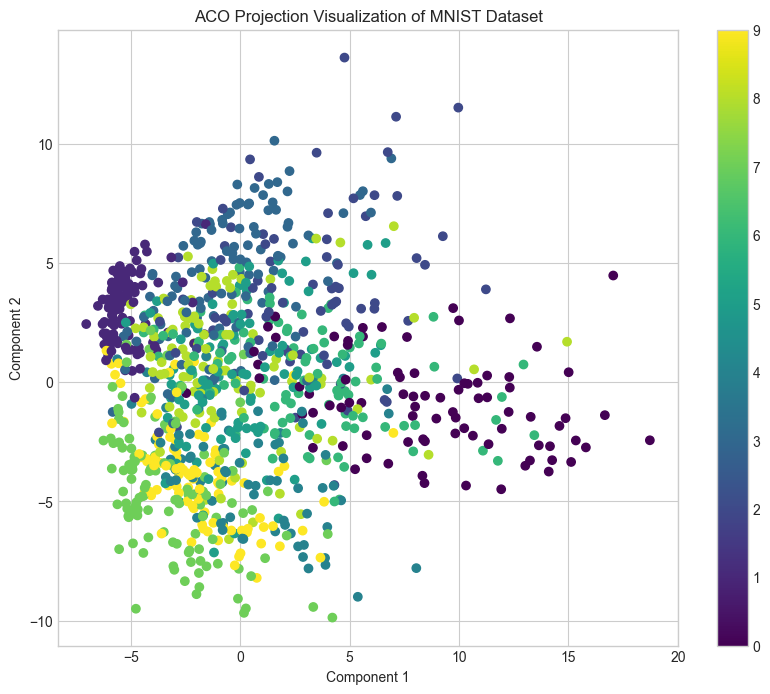

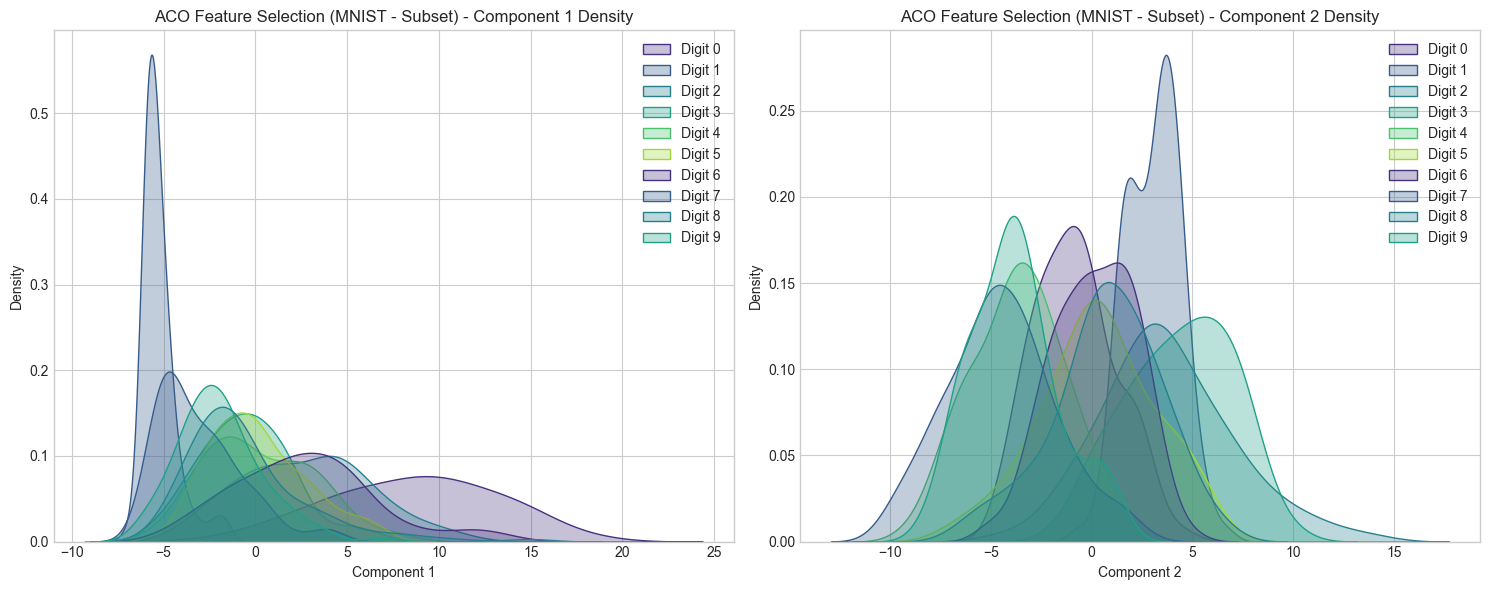

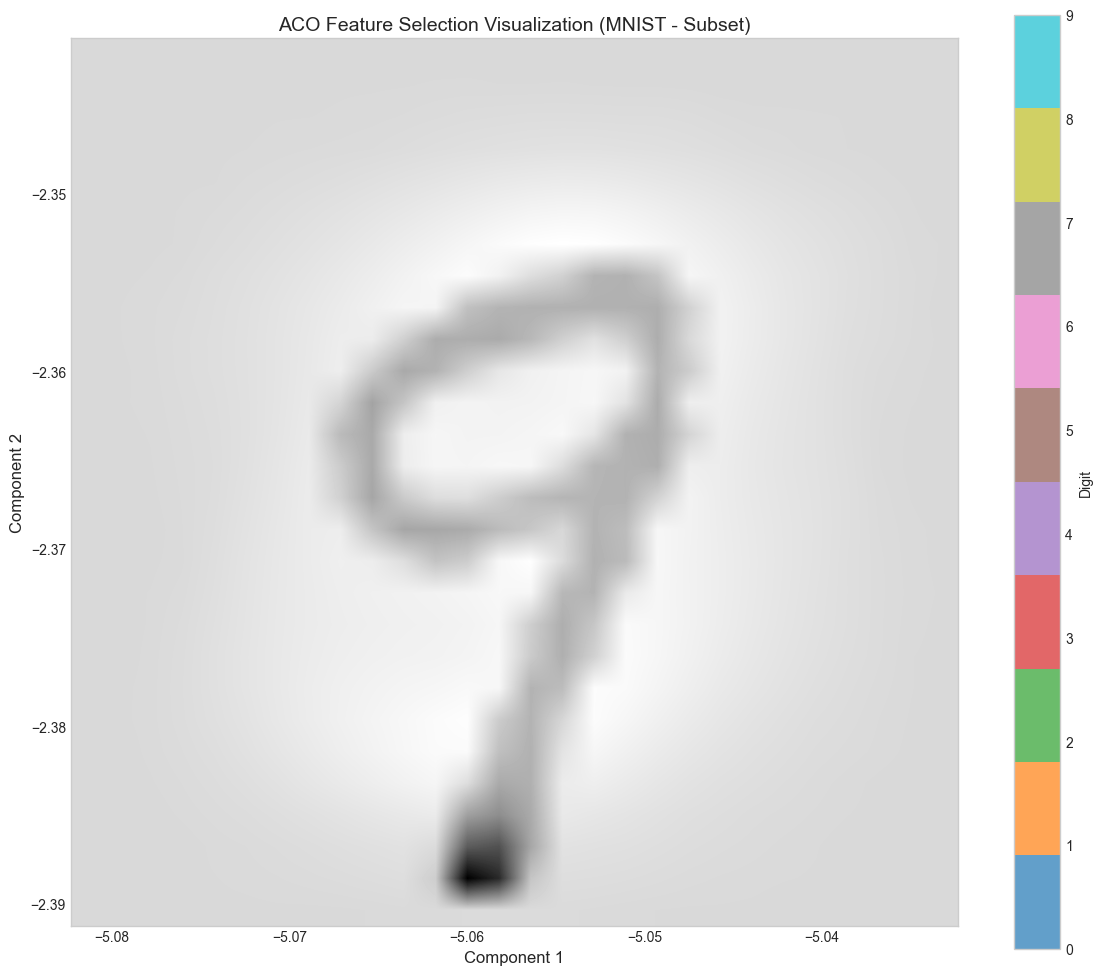

In [27]:
sample_size_aco = 1000
indices_aco = np.random.choice(X.shape[0], sample_size_aco, replace=False)
X_aco_subset = X[indices_aco]
y_aco_subset = y[indices_aco]

X_aco = dr.aco_feature_selection(X_aco_subset, y_aco_subset, n_ants=20, n_iterations=20, alpha=1, beta=2, rho=0.1)

# Evaluate ACO on the subset
trust_aco = metrics.trustworthiness(X_aco_subset, X_aco)
cont_aco = metrics.continuity(X_aco_subset, X_aco)
knn_acc_aco = metrics.knn_accuracy(X_aco, y_aco_subset)
sil_score_aco = metrics.silhouette_score(X_aco, y_aco_subset)

print(f"ACO Metrics (on {sample_size_aco}-sample subset):")
print(f"Trustworthiness: {trust_aco:.4f}")
print(f"Continuity: {cont_aco:.4f}")
print(f"KNN Accuracy: {knn_acc_aco:.4f}")
print(f"Silhouette Score: {sil_score_aco:.4f}")

# Visualize ACO results
metrics.visualize(X_aco, y_aco_subset, title="ACO Projection Visualization of MNIST Dataset")

# Plot density distribution
plot_density_distribution(X_aco, y_aco_subset, "ACO Feature Selection (MNIST - Subset)")
visualize_digits(X_aco, y_aco_subset, "ACO Feature Selection Visualization (MNIST - Subset)")


PSO Metrics (on 1000-sample subset):
Trustworthiness: 0.5651
Continuity: 0.7578
KNN Accuracy: 0.2800
Silhouette Score: -0.1393


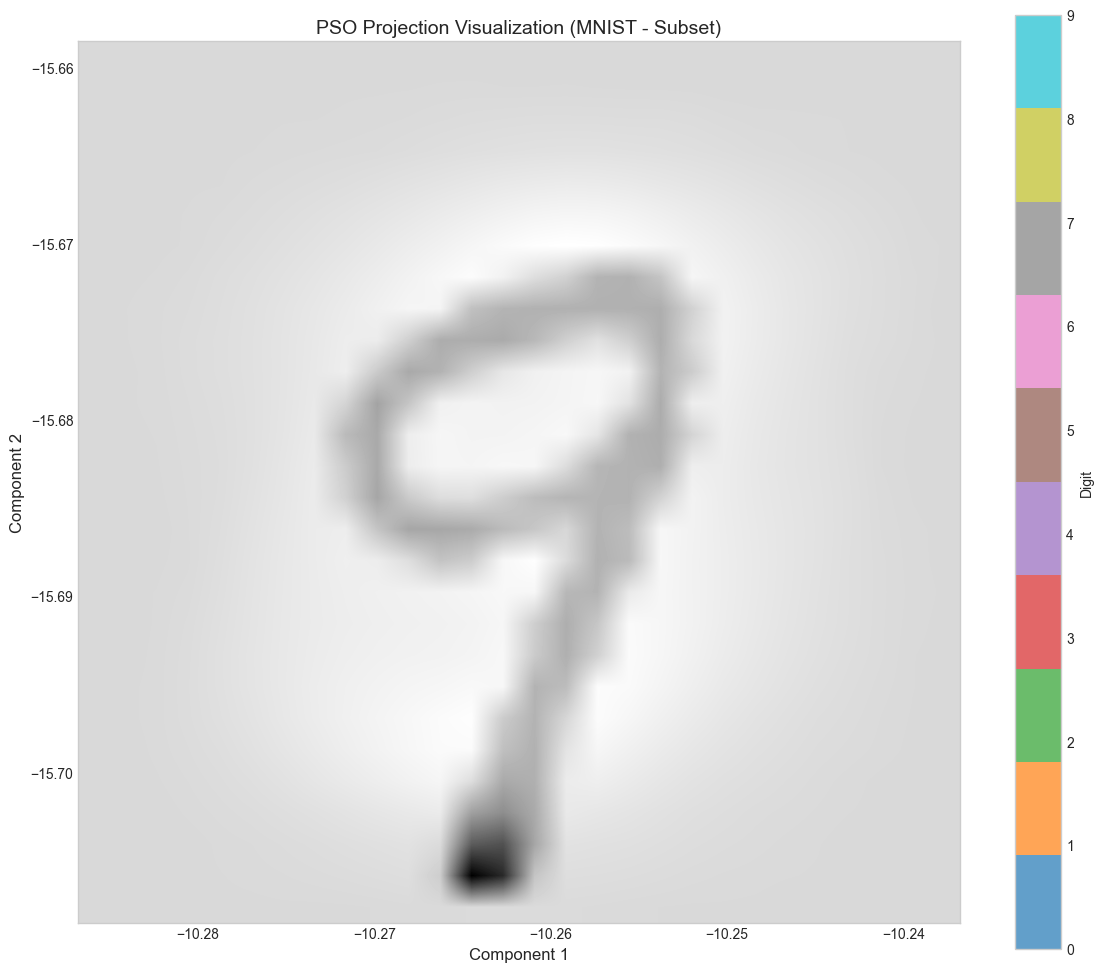

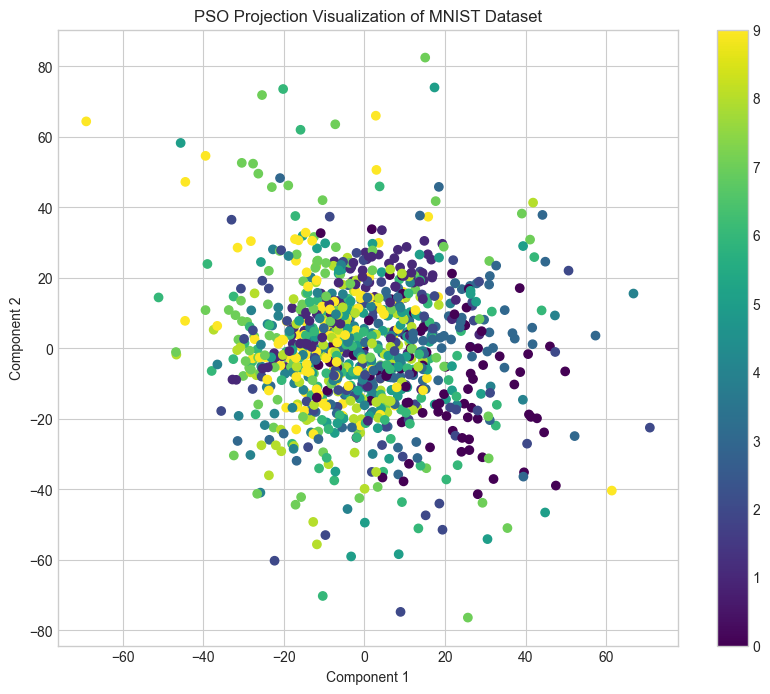

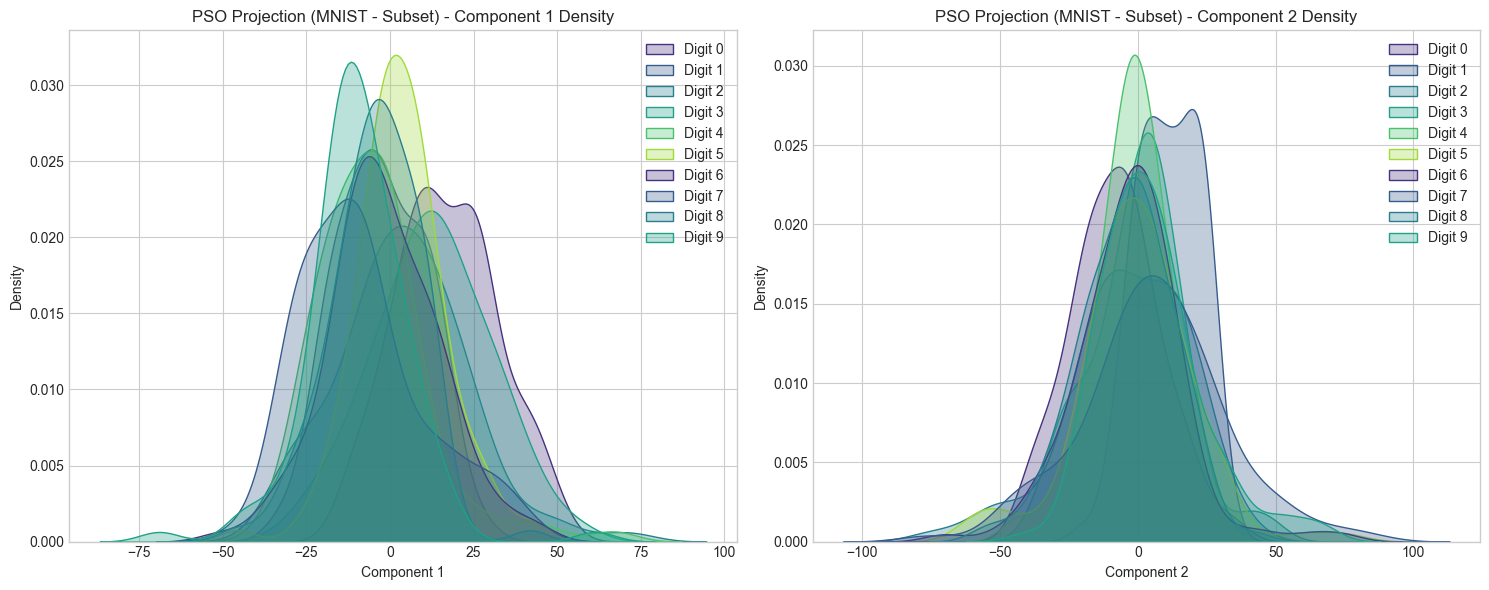

In [28]:
sample_size_pso = 1000
indices_pso = np.random.choice(X.shape[0], sample_size_pso, replace=False)
X_pso_subset = X[indices_pso]
y_pso_subset = y[indices_pso]

X_pso = dr.pso_projection(X_pso_subset, y_pso_subset, n_particles=20, n_iterations=20, w=0.7, c1=1.5, c2=1.5)

# Evaluate PSO on the subset
trust_pso = metrics.trustworthiness(X_pso_subset, X_pso)
cont_pso = metrics.continuity(X_pso_subset, X_pso)
knn_acc_pso = metrics.knn_accuracy(X_pso, y_pso_subset)
sil_score_pso = metrics.silhouette_score(X_pso, y_pso_subset)

print(f"PSO Metrics (on {sample_size_pso}-sample subset):")
print(f"Trustworthiness: {trust_pso:.4f}")
print(f"Continuity: {cont_pso:.4f}")
print(f"KNN Accuracy: {knn_acc_pso:.4f}")
print(f"Silhouette Score: {sil_score_pso:.4f}")

# Visualize PSO results
visualize_digits(X_pso, y_pso_subset, "PSO Projection Visualization (MNIST - Subset)")
metrics.visualize(X_pso, y_pso_subset, title="PSO Projection Visualization of MNIST Dataset")

# Plot density distribution
plot_density_distribution(X_pso, y_pso_subset, "PSO Projection (MNIST - Subset)")

In [29]:
techniques = ['PCA', 'LDA', 't-SNE', 'MDS*', 'Isomap*', 'ICA', 'SOM', 'GA-PCA*', 'ABC*', 'ACO*', 'PSO*']
trustworthiness = [trust_pca, trust_lda, trust_tsne, trust_mds, trust_isomap, trust_ica, 
                  trust_som, trust_ga_pca, trust_abc, trust_aco, trust_pso]
continuity = [cont_pca, cont_lda, cont_tsne, cont_mds, cont_isomap, cont_ica, 
             cont_som, cont_ga_pca, cont_abc, cont_aco, cont_pso]
knn_accuracy = [knn_acc_pca, knn_acc_lda, knn_acc_tsne, knn_acc_mds, knn_acc_isomap, knn_acc_ica, 
               knn_acc_som, knn_acc_ga_pca, knn_acc_abc, knn_acc_aco, knn_acc_pso]
silhouette = [sil_score_pca, sil_score_lda, sil_score_tsne, sil_score_mds, sil_score_isomap, sil_score_ica, 
             sil_score_som, sil_score_ga_pca, sil_score_abc, sil_score_aco, sil_score_pso]

# Create a DataFrame
results_df = pd.DataFrame({
    'Technique': techniques,
    'Trustworthiness': trustworthiness,
    'Continuity': continuity,
    'KNN Accuracy': knn_accuracy,
    'Silhouette Score': silhouette
})

# Display the results
print("Note: Techniques marked with * were applied on a reduced subset of 1000 samples due to computational constraints.")
results_df

Note: Techniques marked with * were applied on a reduced subset of 1000 samples due to computational constraints.


Technique  Trustworthiness  Continuity  KNN Accuracy  Silhouette Score
0        PCA         0.670605    0.932401         0.306         -0.075063
1        LDA         0.620076    0.883069         0.485          0.037369
2      t-SNE         0.967976    0.970530         0.890          0.097200
3       MDS*         0.690094    0.840227         0.430         -0.101374
4    Isomap*         0.700142    0.922176         0.455         -0.049231
5        ICA         0.577862    0.847396         0.166         -0.252541
6        SOM         0.880616    0.890800         0.743         -0.013010
7    GA-PCA*         0.658886    0.892509         0.375         -0.051661
8       ABC*         0.598107    0.779434         0.330         -0.137710
9       ACO*         0.661044    0.895437         0.480         -0.005841
10      PSO*         0.565093    0.757831         0.280         -0.139327

C:\Users\LapTop\AppData\Local\Temp\ipykernel_24716\279482896.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\LapTop\AppData\Local\Temp\ipykernel_24716\279482896.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\LapTop\AppData\Local\Temp\ipykernel_24716\279482896.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\LapTop\AppData\Local\Temp\ipykernel_24716\279482896.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickla

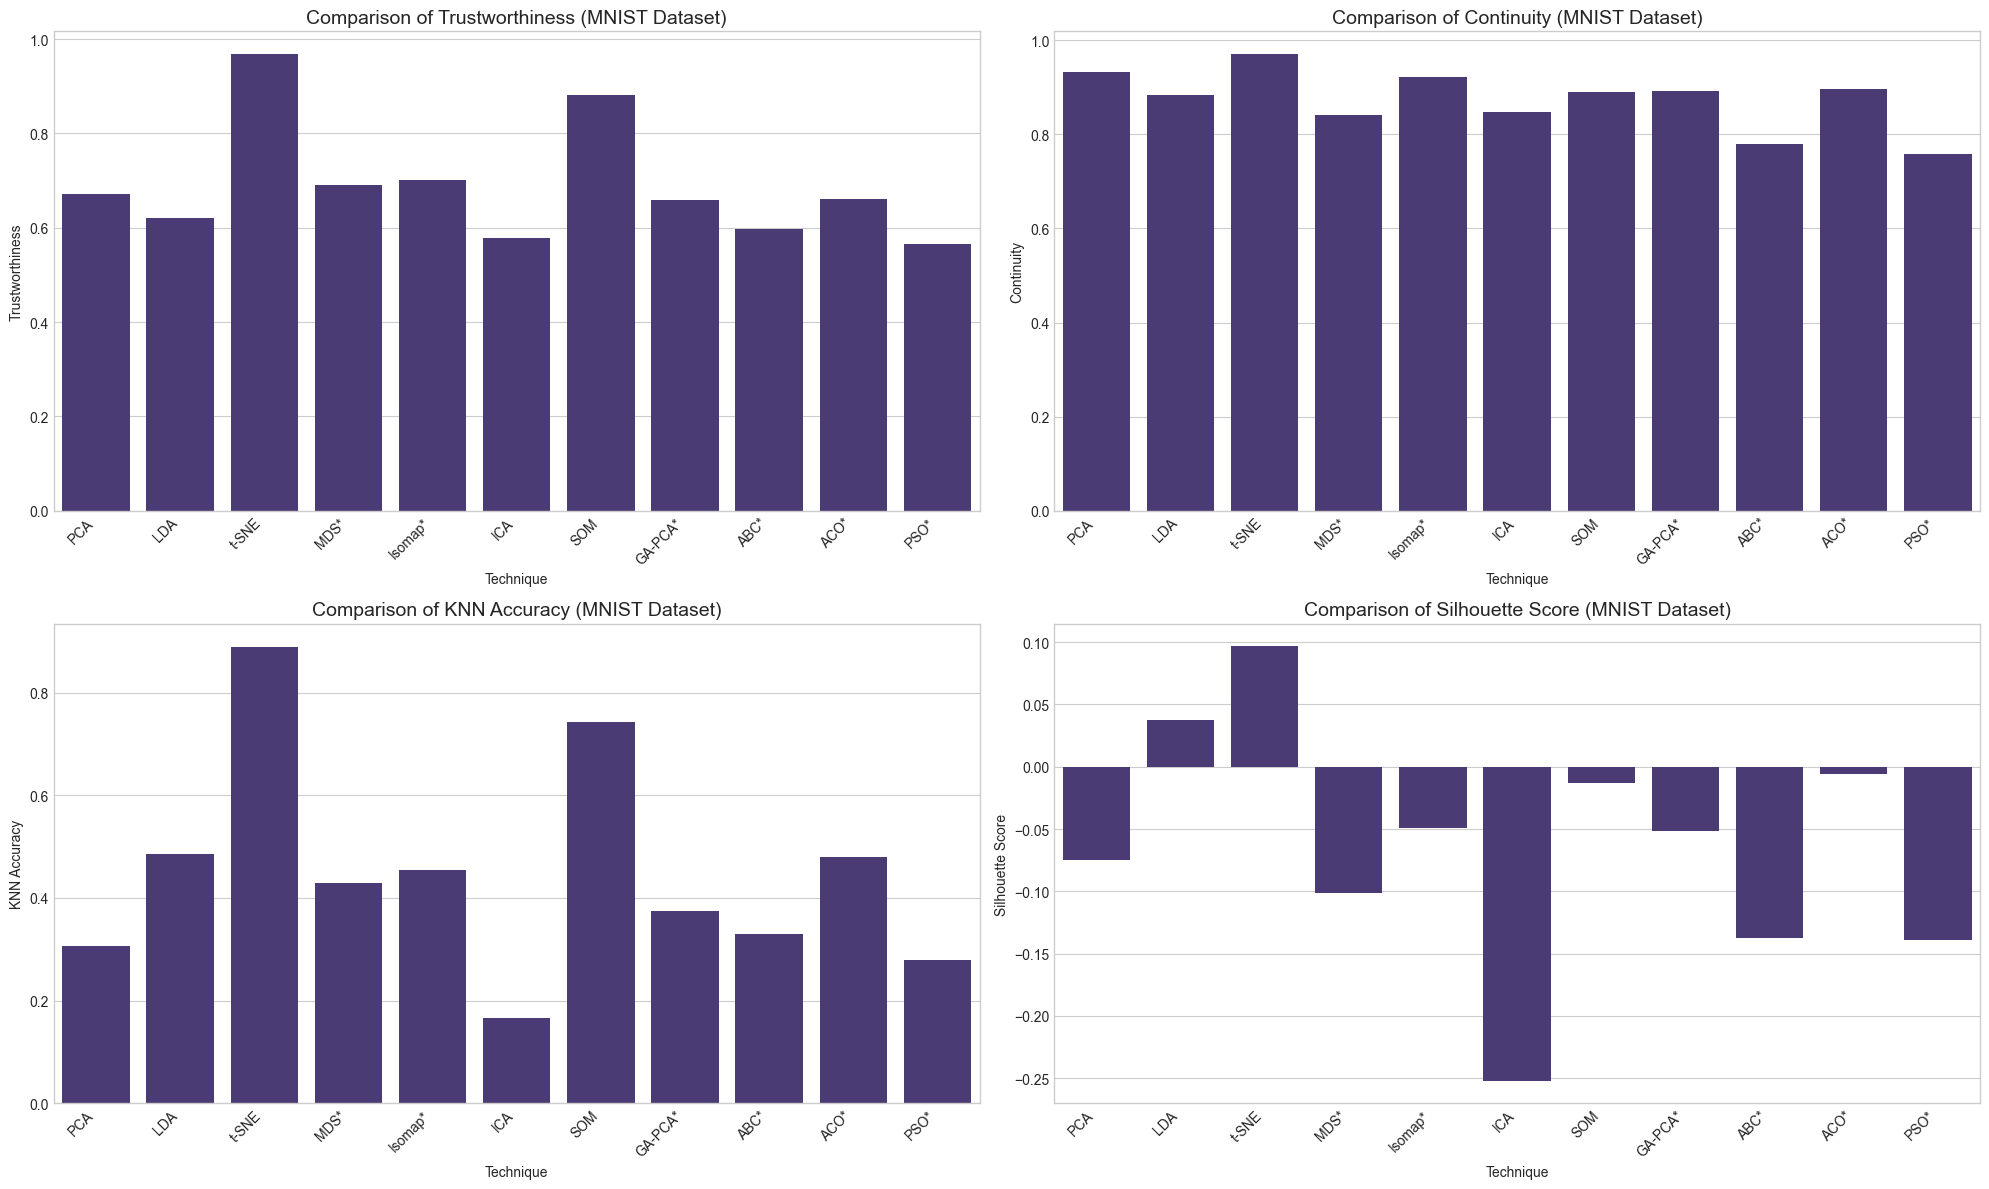

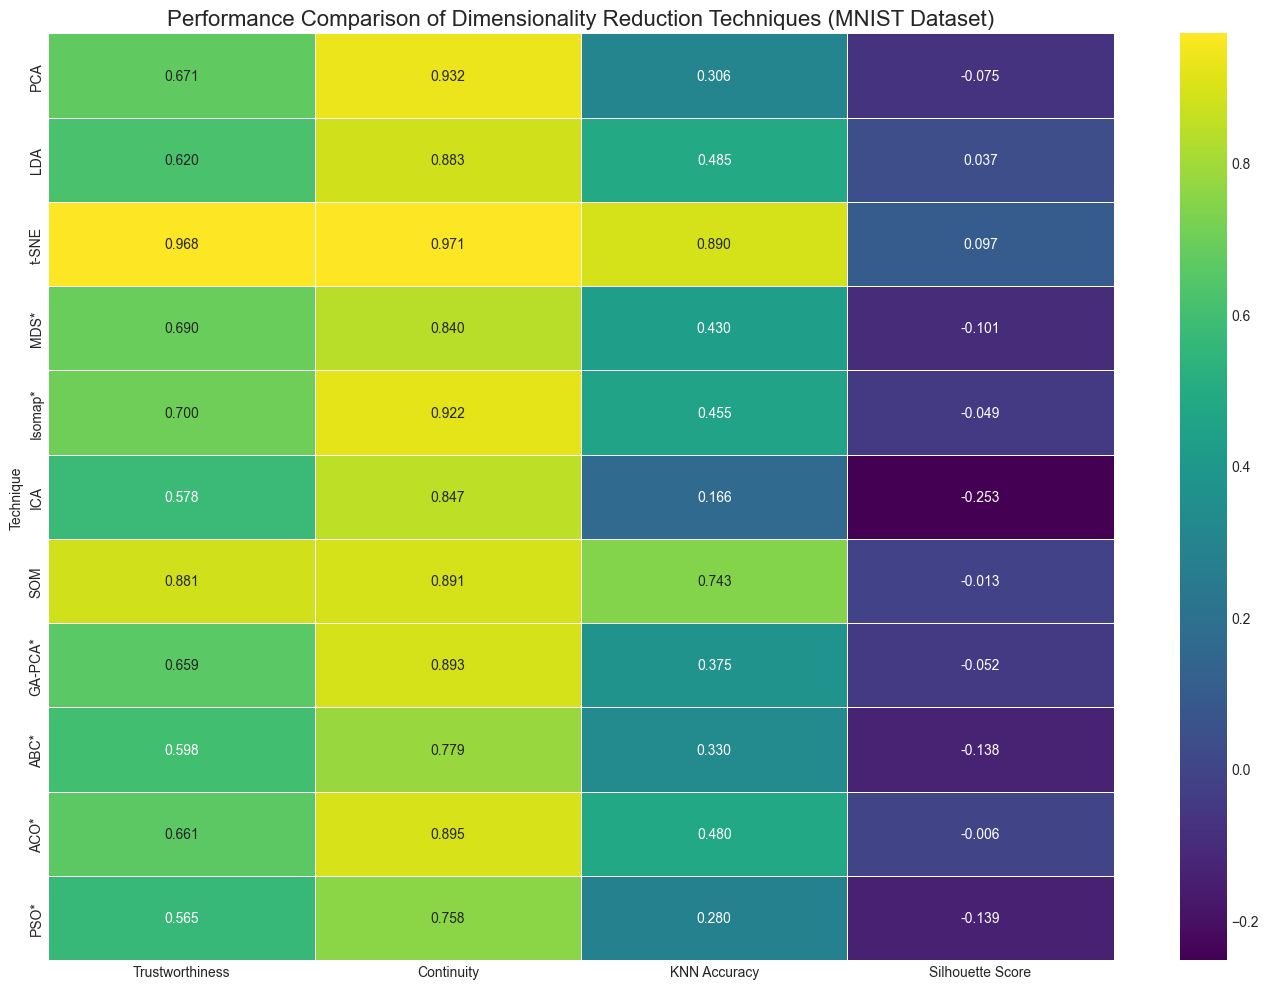

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
metrics_to_plot = ['Trustworthiness', 'Continuity', 'KNN Accuracy', 'Silhouette Score']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    sns.barplot(x='Technique', y=metric, data=results_df, ax=ax)
    ax.set_title(f'Comparison of {metric} (MNIST Dataset)', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

# %%
# Heatmap visualization of results
plt.figure(figsize=(14, 10))
metrics_heatmap = results_df.set_index('Technique')
sns.heatmap(metrics_heatmap, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
plt.title('Performance Comparison of Dimensionality Reduction Techniques (MNIST Dataset)', fontsize=16)
plt.tight_layout()
plt.show()


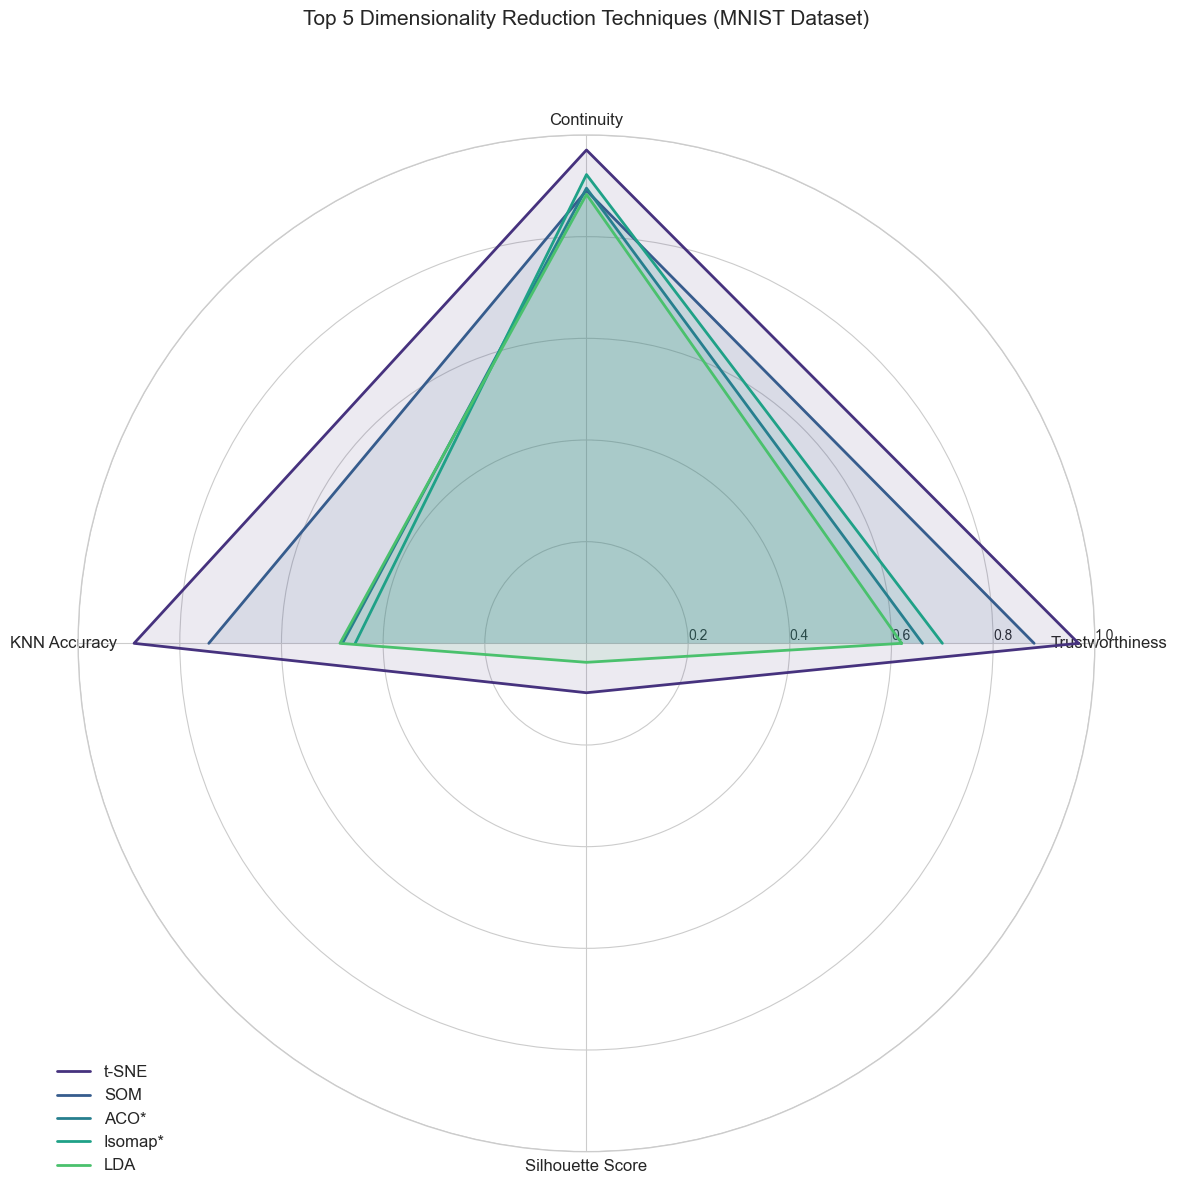

In [31]:
from math import pi

# Select top 5 techniques based on average metrics
metrics_heatmap['Average'] = metrics_heatmap.mean(axis=1)
top_5 = metrics_heatmap.nlargest(5, 'Average').drop('Average', axis=1)

# Prepare data for radar chart
categories = list(top_5.columns)
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create figure
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Add each technique as a line on the radar chart
for technique, values in top_5.iterrows():
    values_list = values.tolist()
    values_list += values_list[:1]  # Close the loop
    ax.plot(angles, values_list, linewidth=2, label=technique)
    ax.fill(angles, values_list, alpha=0.1)

# Set the labels and styling
plt.xticks(angles[:-1], categories, fontsize=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
plt.ylim(0, 1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
plt.title('Top 5 Dimensionality Reduction Techniques (MNIST Dataset)', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()